# Assignment: Responsible Machine Learning Class by Professor Hall

## Set up & fit models

In [1]:
import datetime                                               # for timestamp 
import time                                                   # for timers

import h2o                                                    # base h2o package for python
from h2o.estimators.gbm import H2OGradientBoostingEstimator   # h2o GBM
from h2o.grid.grid_search import H2OGridSearch                # h2o grid search
from h2o.automl import H2OAutoML                              # h2o auto machine learning models
import math                                                   # math functions

import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation

import xgboost as xgb                                         # base xgboost package for python


# set numpy random seed for better reproducibility
SEED = 12345 

# preserve exact reproducibility globally
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 19 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_minhyekim_e0uu03
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.958 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [2]:
# start global timer
tic = time.time()

In [3]:
# load datasets
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

In [4]:
# define features to use
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

In [32]:
# 70%/30% train/test split
split_ratio = 0.7 

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 112343, columns = 23
Validation data rows = 47995, columns = 23


In [6]:
# convert data to h2o frames
htrain = h2o.H2OFrame(train, column_types={'high_priced':'enum'})
hvalid = h2o.H2OFrame(valid, column_types={'high_priced':'enum'})

In [7]:
# set monotonic constraints for numerical columns
numeric_x_names = ['loan_amount_std', 'loan_to_value_ratio_std', 'intro_rate_period_std',
                   'property_value_std', 'income_std', 'debt_to_income_ratio_std']
mono = tuple([int(i) for i in np.sign(train[numeric_x_names + [y_name]].corr()[y_name].values[:-1])])
numeric_dict = dict(zip(numeric_x_names,mono))

binary_dict = {'conforming': 0, 'debt_to_income_ratio_missing': 0, 'no_intro_rate_period_std': 0, 'term_360': 0}

monotone_constraints = {**numeric_dict, **binary_dict}
monotone_constraints

{'loan_amount_std': -1,
 'loan_to_value_ratio_std': 1,
 'intro_rate_period_std': -1,
 'property_value_std': -1,
 'income_std': -1,
 'debt_to_income_ratio_std': 1,
 'conforming': 0,
 'debt_to_income_ratio_missing': 0,
 'no_intro_rate_period_std': 0,
 'term_360': 0}

### MGBM _ H2O Gradient Boosting Estimator

In [8]:
# start local timer
gbm_tic = time.time()

# train a mgbm model
best_gbm = H2OGradientBoostingEstimator(
    
    ntrees = 10000,                                                            

    ## smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
    learn_rate = 0.01,                                                         

    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
    stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC",                                                  

    ## sample 80% of columns per split
    col_sample_rate = 0.8,                                                   

    ## fix the seed for reproducibility
    seed = SEED,                                                             

    ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
    score_tree_interval = 10,
                                  
    ## monotonic constraints
    monotone_constraints=monotone_constraints)

best_gbm.train(x=x_names, y=y_name, training_frame=htrain, validation_frame=hvalid)

# end local timer
gbm_toc = time.time() - gbm_tic

print('GBM training completed in %.2f s.' % (gbm_toc))

GBM training completed in 64.35 s.


In [9]:
# create a submission file
best_gbm_submit = best_gbm.predict(h2o.H2OFrame(test)).as_data_frame() 
best_gbm_submit.drop(['predict', '0.0'], axis=1, inplace=True)
best_gbm_submit.columns = ['phat']
best_gbm_submit.to_csv('group5_mgbm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

In [10]:
# end global timer 
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 75.48 s.


### H2O Explain


18:38:56.960: AutoML: XGBoost is not available; skipping it.



# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_AutoML_20210606_183856,0.81935,0.25629,0.291197,0.281603,0.276907,0.0766776,3179,0.019784,StackedEnsemble
StackedEnsemble_BestOfFamily_AutoML_20210606_183856,0.817461,0.257235,0.288268,0.280756,0.277241,0.0768628,2073,0.005908,StackedEnsemble
GBM_2_AutoML_20210606_183856,0.817143,0.26317,0.287769,0.277876,0.278305,0.0774539,1197,0.002203,GBM
GBM_3_AutoML_20210606_183856,0.817106,0.264274,0.287267,0.281001,0.278506,0.0775656,1131,0.002111,GBM
GBM_4_AutoML_20210606_183856,0.816938,0.265539,0.288369,0.271256,0.278731,0.0776911,1179,0.002235,GBM
GBM_grid__1_AutoML_20210606_183856_model_2,0.815572,0.258493,0.280858,0.276041,0.277763,0.0771522,2583,0.005511,GBM
GBM_1_AutoML_20210606_183856,0.815443,0.264175,0.284131,0.281489,0.278801,0.0777299,1186,0.002306,GBM
GBM_5_AutoML_20210606_183856,0.814636,0.27089,0.283625,0.280915,0.280448,0.0786511,1192,0.002029,GBM
GBM_grid__1_AutoML_20210606_183856_model_1,0.813706,0.259714,0.273161,0.280836,0.278295,0.0774478,2801,0.005757,GBM
GBM_grid__1_AutoML_20210606_183856_model_3,0.799789,0.276391,0.258756,0.311822,0.28293,0.0800496,572,0.001473,GBM


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_AutoML_20210606_183856


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1627820894898968: 


,,0.0,1.0,Error,Rate
0,0.0,7062.0,1858.0,0.2083,(1858.0/8920.0)
1,1.0,297.0,712.0,0.2944,(297.0/1009.0)
2,Total,7359.0,2570.0,0.217,(2155.0/9929.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

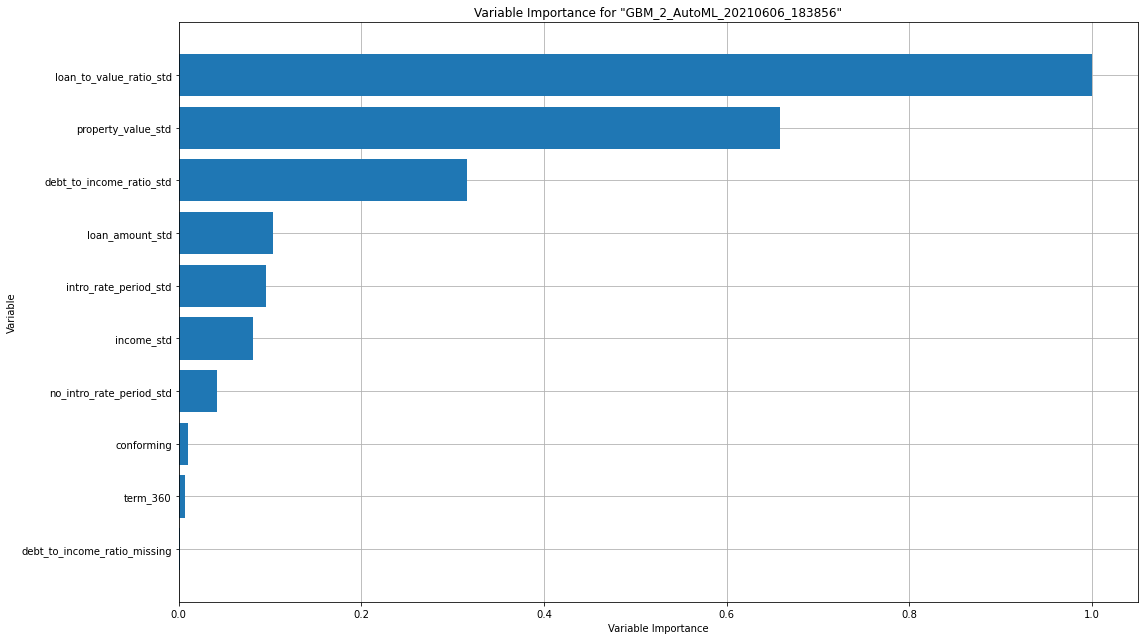

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

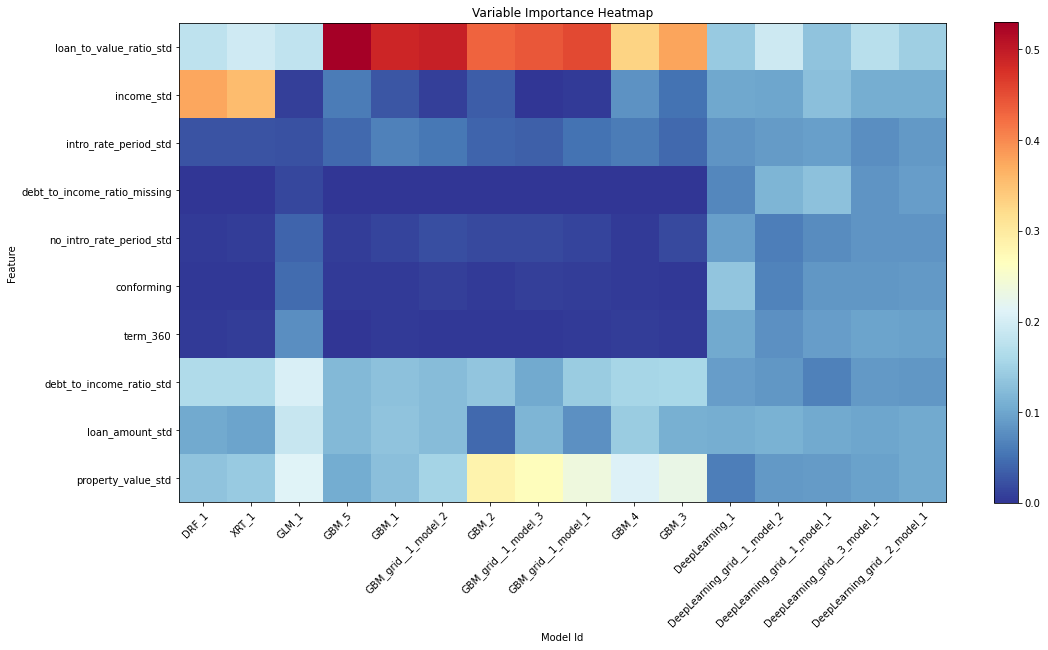

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

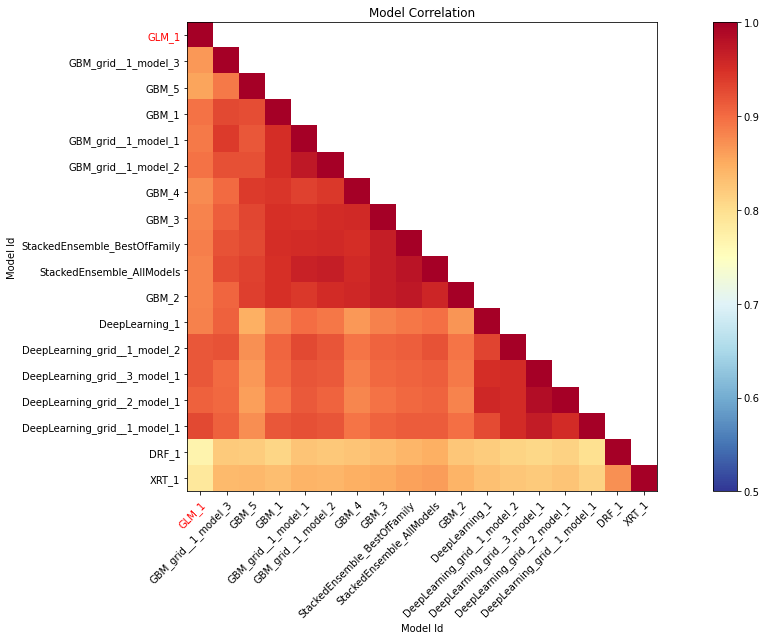

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

C:\Users\minhyekim\Anaconda3\lib\site-packages\h2o\explanation\_explain.py:514: RuntimeWarning: invalid value encountered in true_divide
  res = (res - np.nanmin(res)) / (np.nanmax(res) - np.nanmin(res))


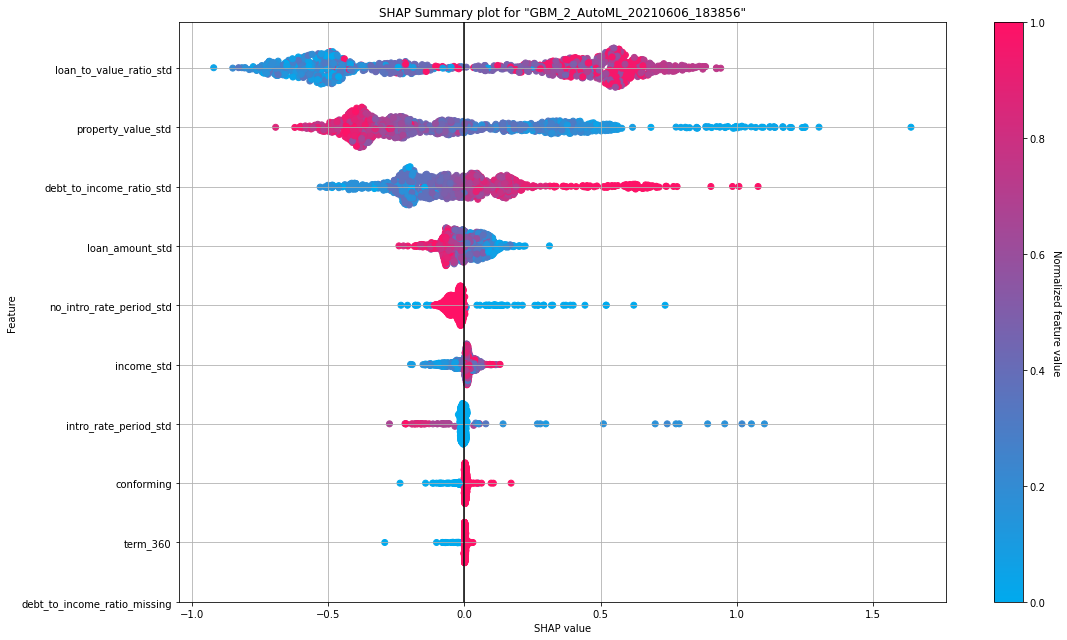

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

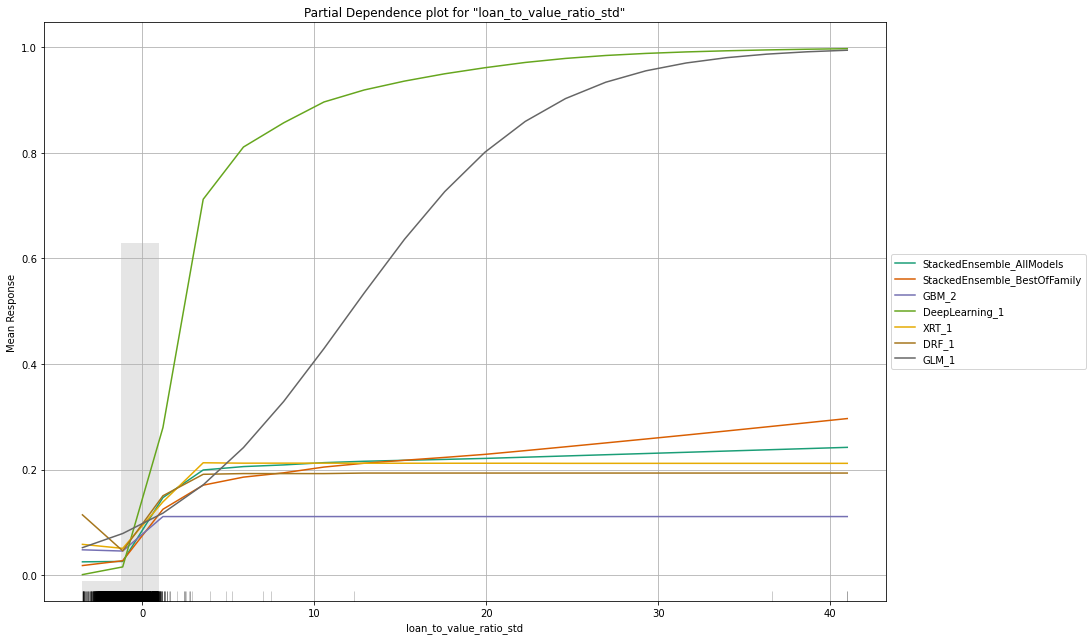

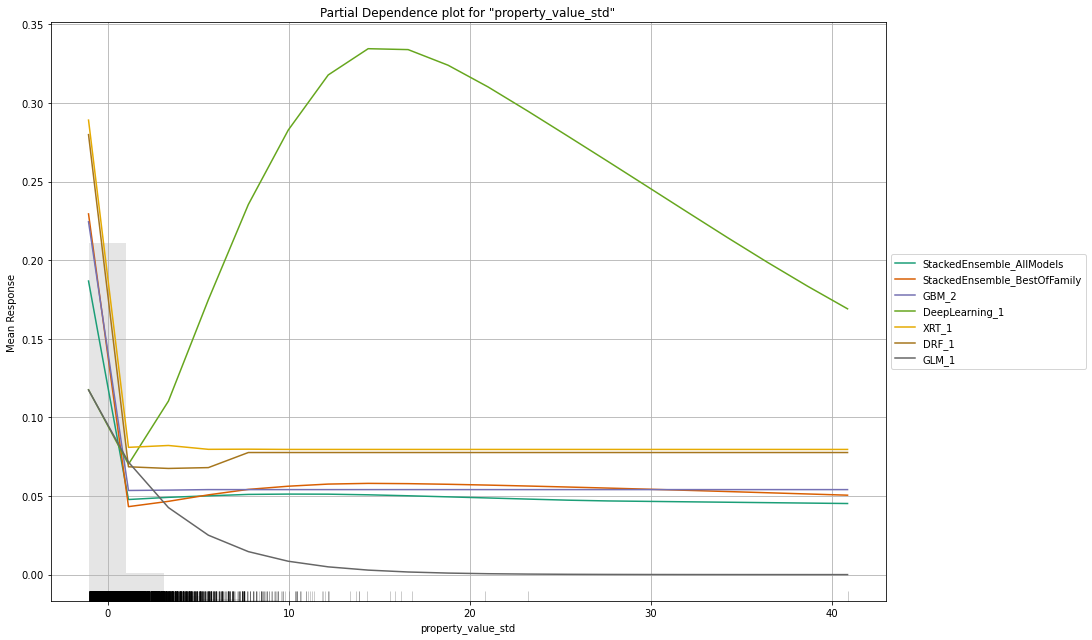

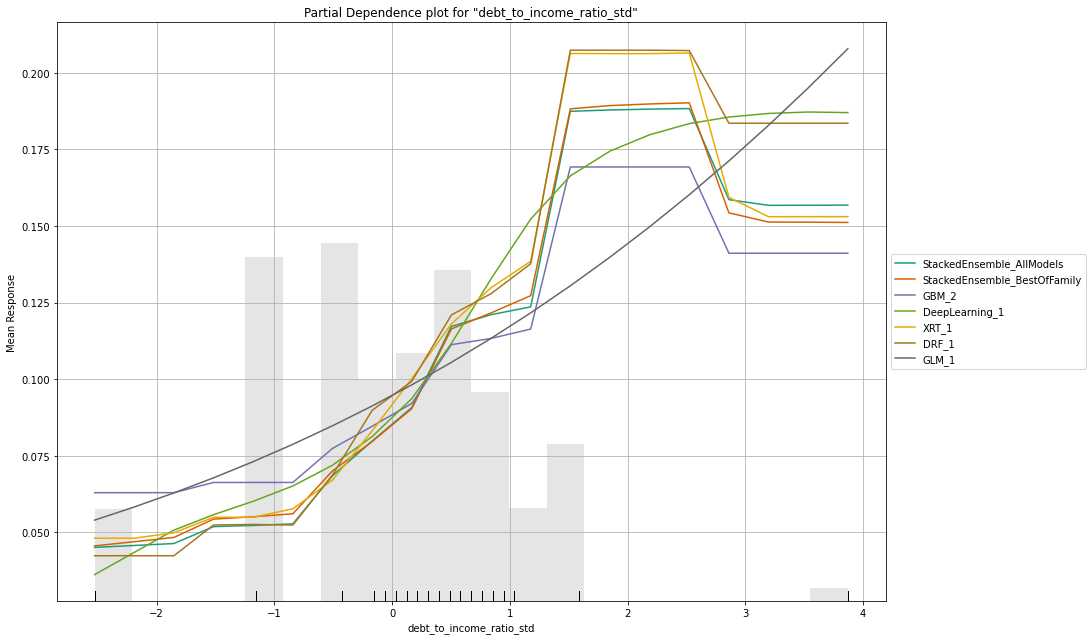

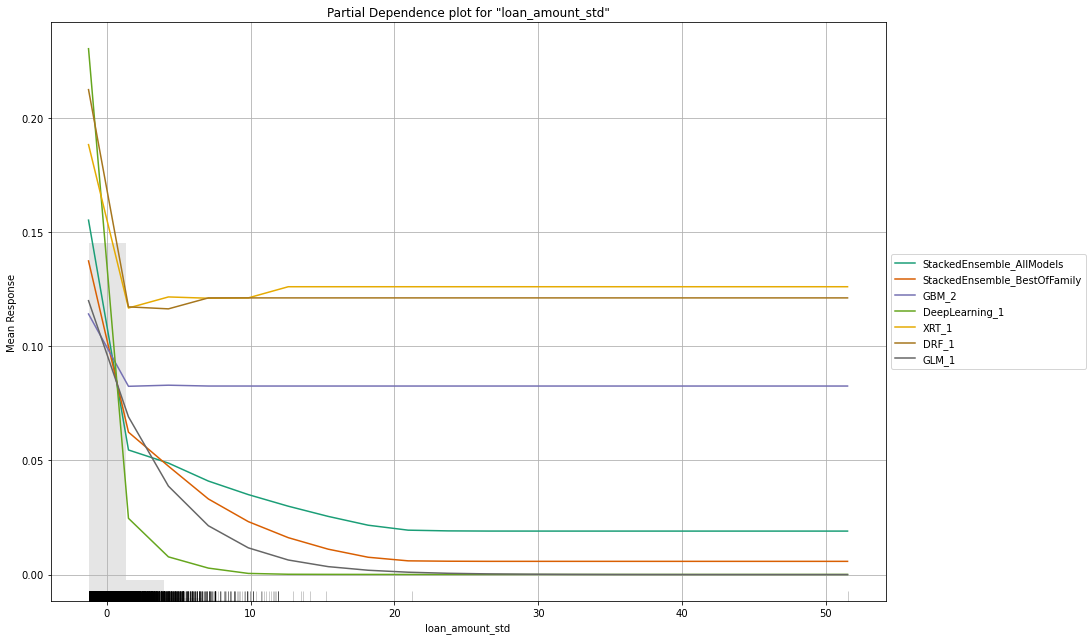

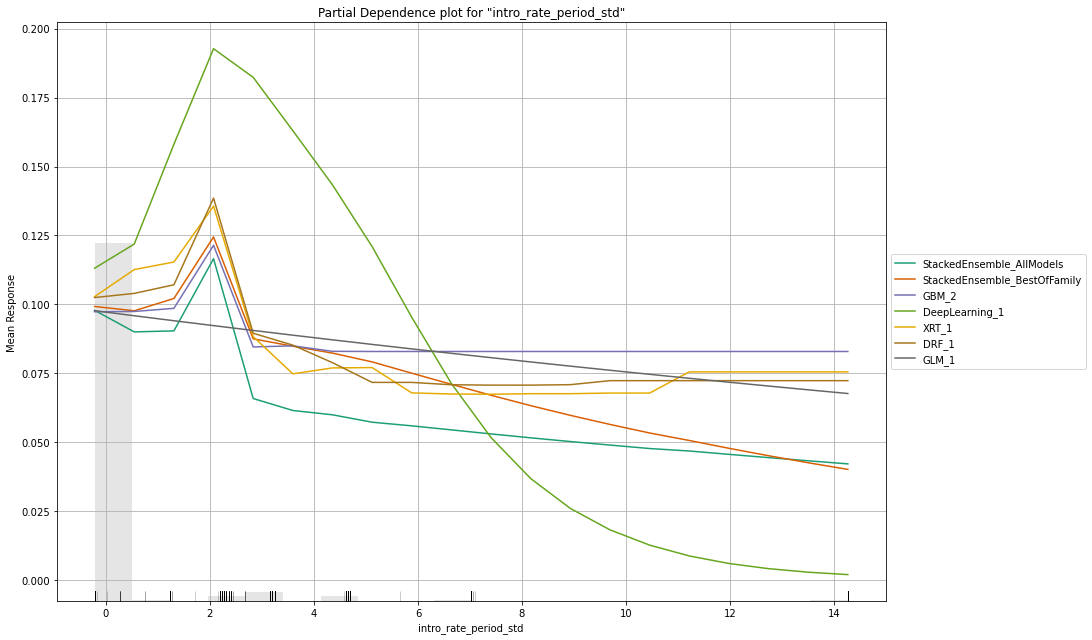

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_AutoML_20210606_183856


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1627820894898968: 


,,0.0,1.0,Error,Rate
0,0.0,7062.0,1858.0,0.2083,(1858.0/8920.0)
1,1.0,297.0,712.0,0.2944,(297.0/1009.0)
2,Total,7359.0,2570.0,0.217,(2155.0/9929.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

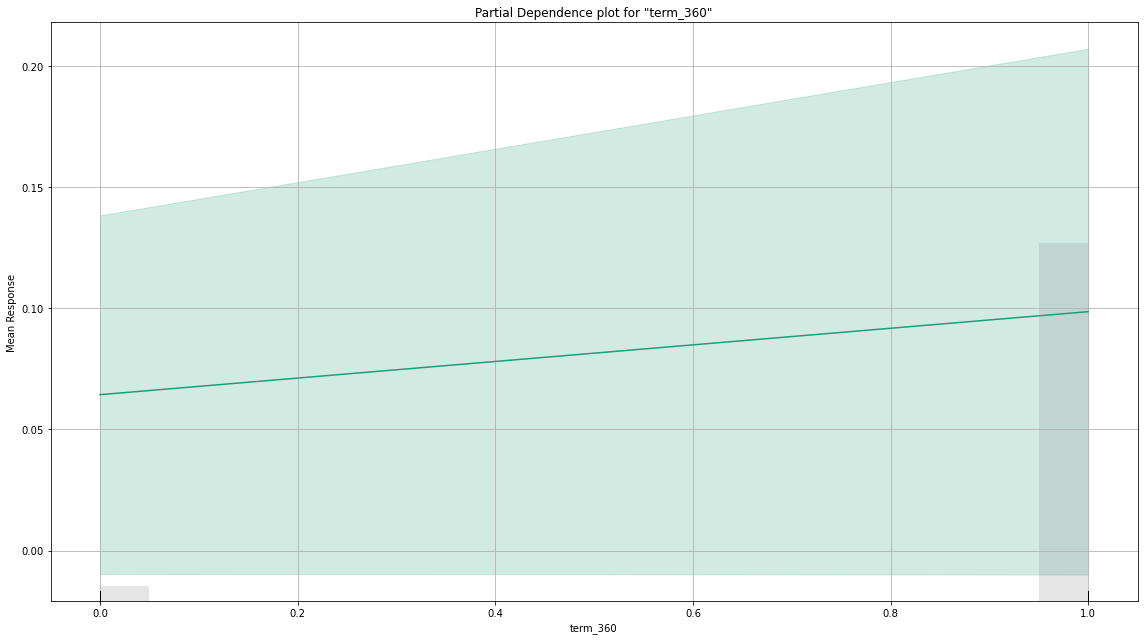

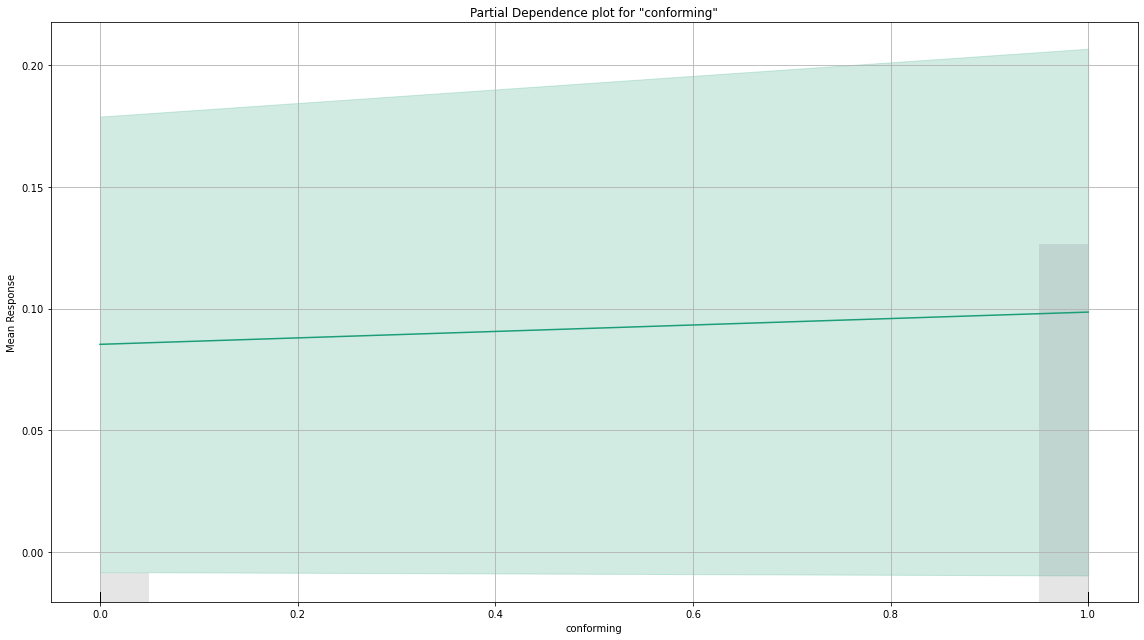

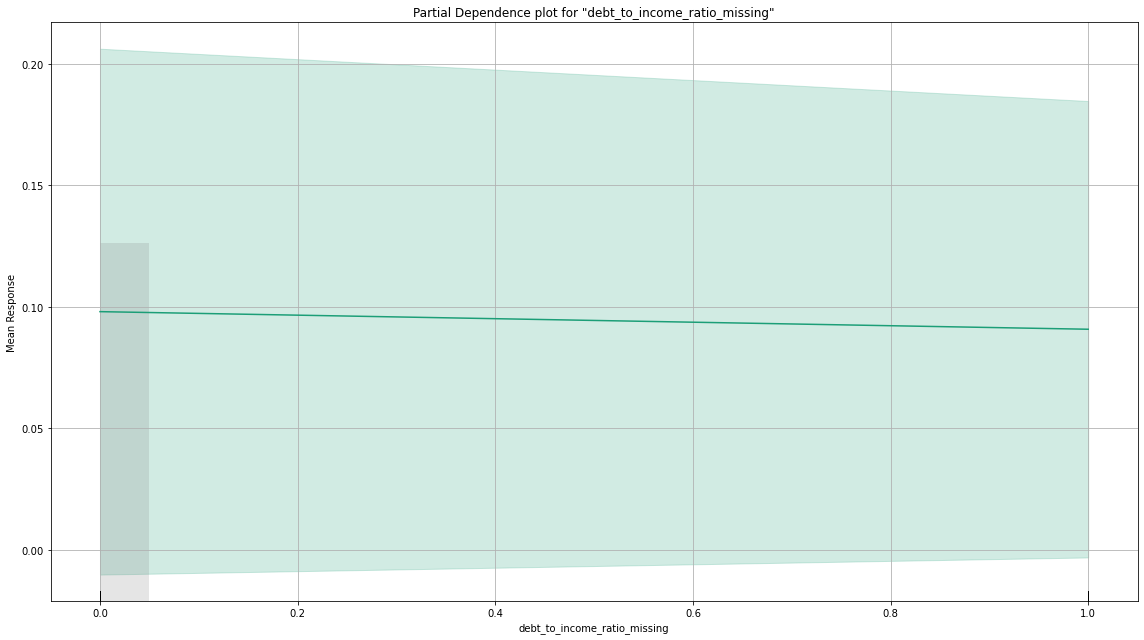

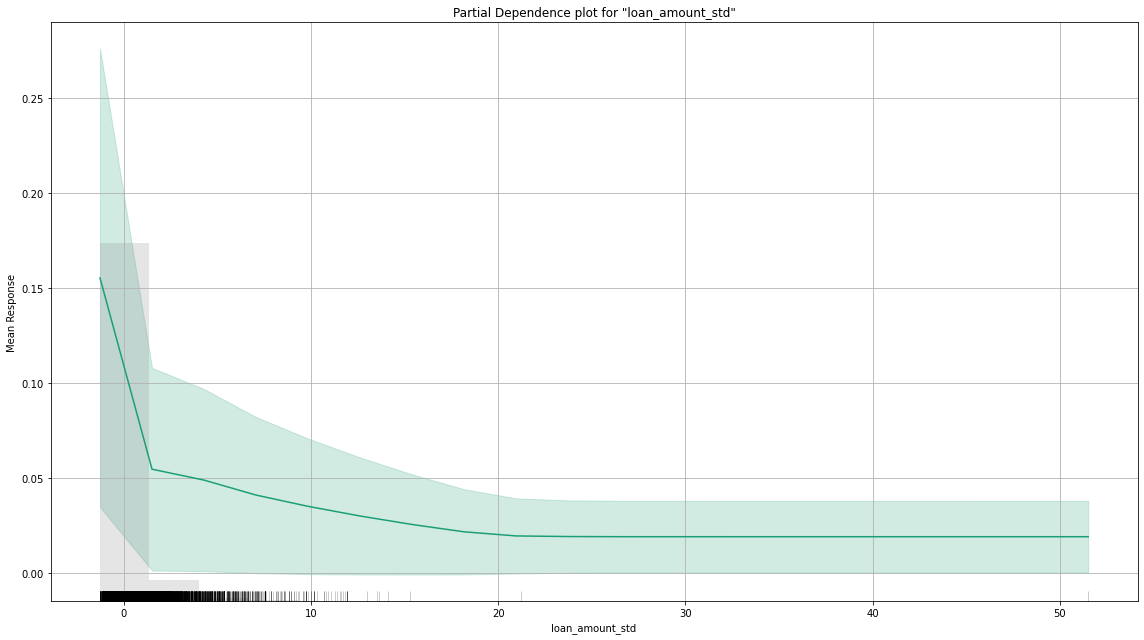

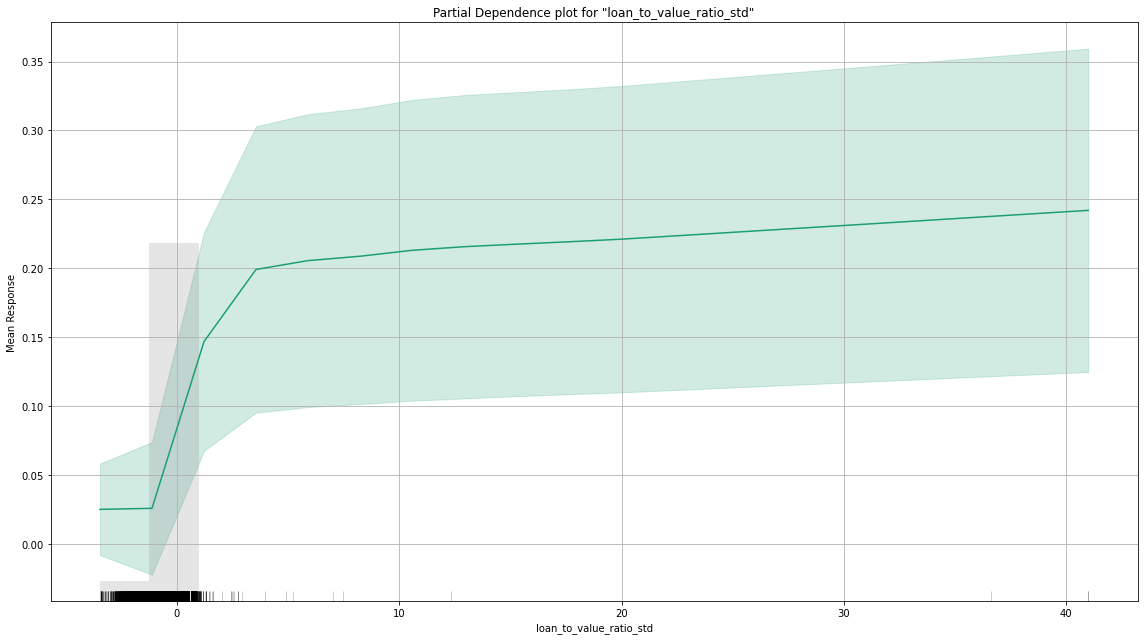

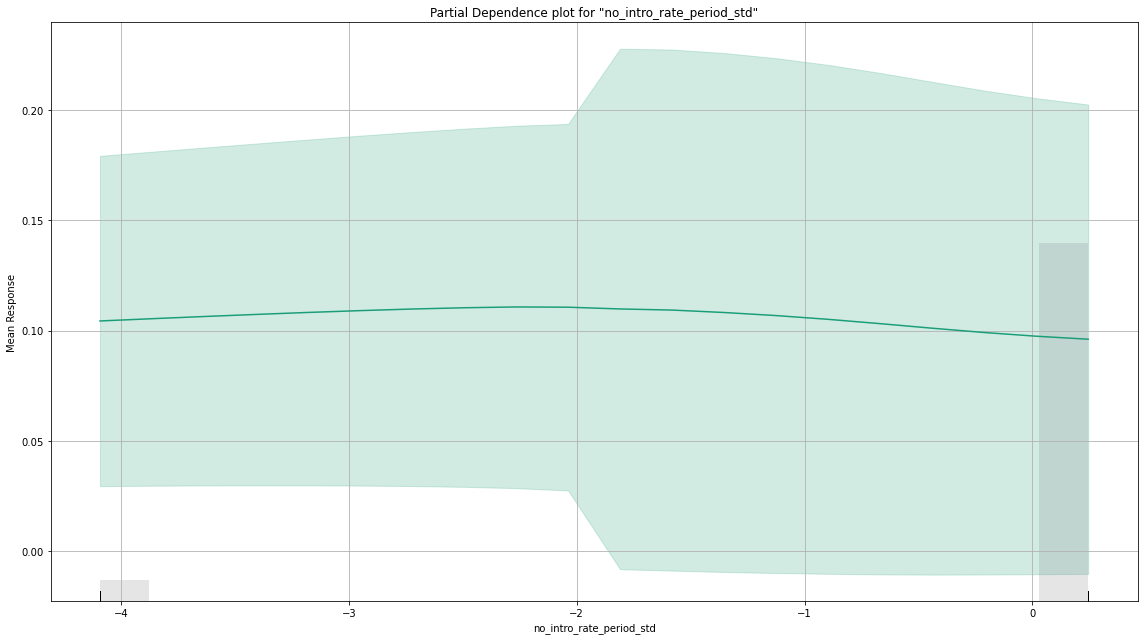

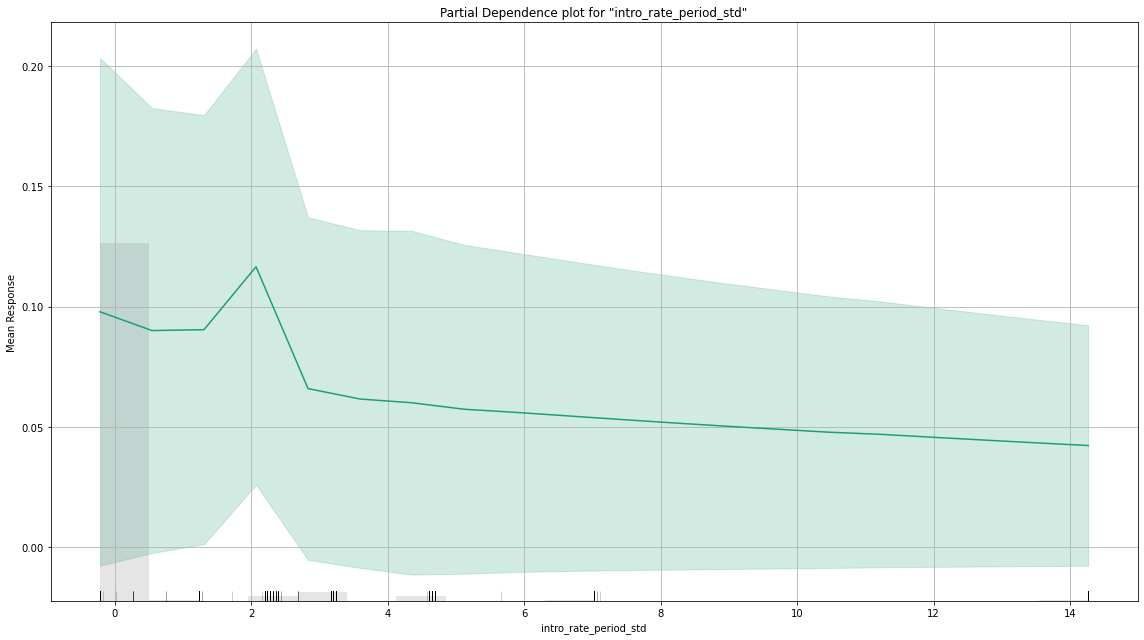

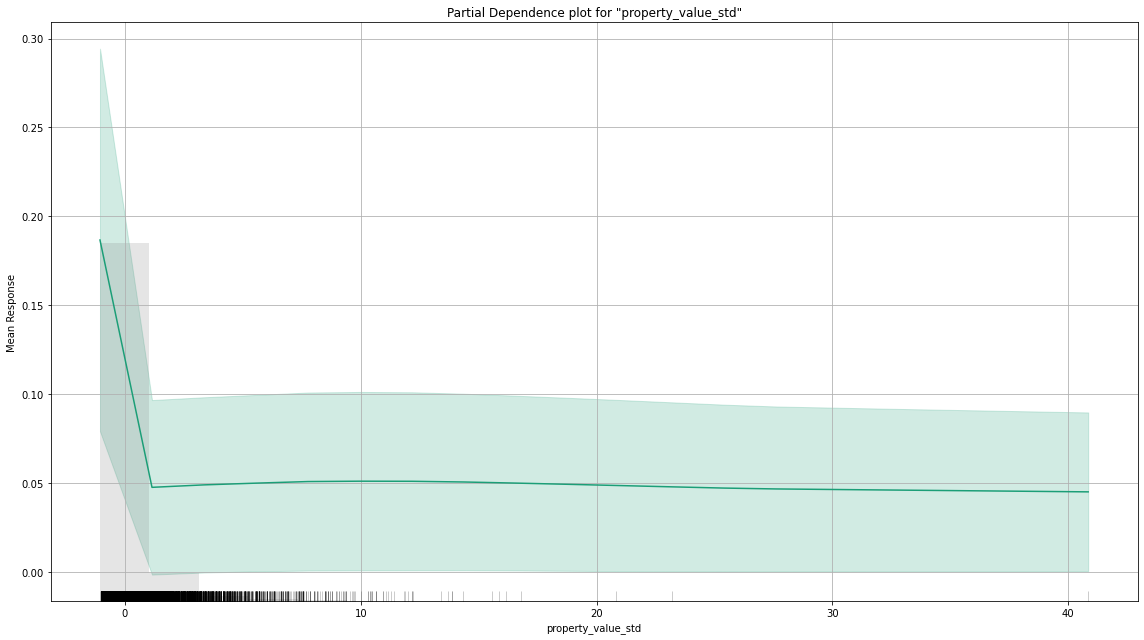

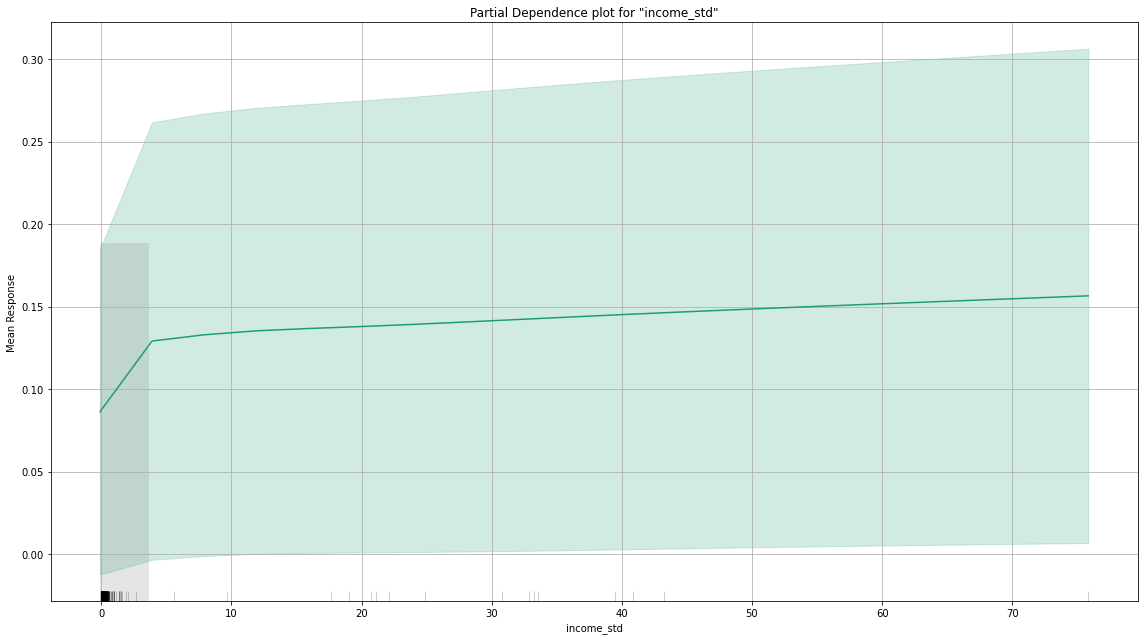

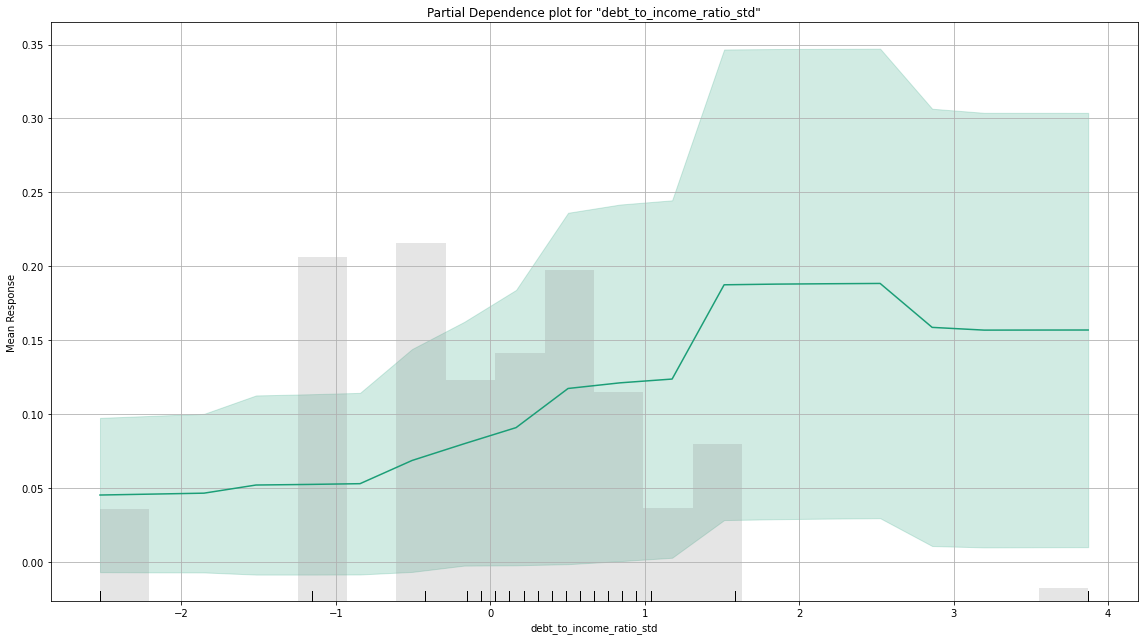

In [11]:
# use top models for submission

# Run AutoML for 3 minutes
aml = H2OAutoML(max_runtime_secs=180, seed=SEED)
aml.train(x=x_names, y=y_name, training_frame=htrain)

# Explain leader model & compare with all AutoML models
exa = aml.explain(hvalid)

In [12]:
lb = aml.leaderboard
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210606_183856,0.81935,0.25629,0.291197,0.281603,0.276907,0.0766776
StackedEnsemble_BestOfFamily_AutoML_20210606_183856,0.817461,0.257235,0.288268,0.280756,0.277241,0.0768628
GBM_2_AutoML_20210606_183856,0.817143,0.26317,0.287769,0.277876,0.278305,0.0774539
GBM_3_AutoML_20210606_183856,0.817106,0.264274,0.287267,0.281001,0.278506,0.0775656
GBM_4_AutoML_20210606_183856,0.816938,0.265539,0.288369,0.271256,0.278731,0.0776911
GBM_grid__1_AutoML_20210606_183856_model_2,0.815572,0.258493,0.280858,0.276041,0.277763,0.0771522
GBM_1_AutoML_20210606_183856,0.815443,0.264175,0.284131,0.281489,0.278801,0.0777299
GBM_5_AutoML_20210606_183856,0.814636,0.27089,0.283625,0.280915,0.280448,0.0786511
GBM_grid__1_AutoML_20210606_183856_model_1,0.813706,0.259714,0.273161,0.280836,0.278295,0.0774478
GBM_grid__1_AutoML_20210606_183856_model_3,0.799789,0.276391,0.258756,0.311822,0.28293,0.0800496


### ENSENBLE _ H2O AUTOML

In [13]:
ensenble_h2o = h2o.get_model(lb[1,"model_id"])

In [14]:
ensenble_h2o

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20210606_183856

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.07386252009324308
RMSE: 0.2717765996057112
LogLoss: 0.24526207161101343
Null degrees of freedom: 9928
Residual degrees of freedom: 9924
Null deviance: 6287.474618206781
Residual deviance: 4870.414218051506
AIC: 4880.414218051506
AUC: 0.8405942939288252
AUCPR: 0.3302165076316786
Gini: 0.6811885878576505

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17808998056654582: 


,,0.0,1.0,Error,Rate
0,0.0,7273.0,1701.0,0.1895,(1701.0/8974.0)
1,1.0,315.0,640.0,0.3298,(315.0/955.0)
2,Total,7588.0,2341.0,0.203,(2016.0/9929.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.178090,0.388350,199.0
1,max f2,0.112456,0.551572,258.0
2,max f0point5,0.278087,0.355905,110.0
3,max accuracy,0.462871,0.905731,25.0
4,max precision,0.839004,1.000000,0.0
5,max recall,0.015290,1.000000,372.0
6,max specificity,0.839004,1.000000,0.0
7,max absolute_mcc,0.160644,0.342077,217.0
8,max min_per_class_accuracy,0.151785,0.759973,225.0
9,max mean_per_class_accuracy,0.100170,0.772835,269.0



Gains/Lift Table: Avg response rate:  9.62 %, avg score:  9.68 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010072,0.404878,5.510335,5.510335,0.530000,0.478519,0.530000,0.478519,0.055497,0.055497,451.033508,451.033508,0.050260
1,2,0.020042,0.364625,3.990713,4.754342,0.383838,0.384368,0.457286,0.431680,0.039791,0.095288,299.071342,375.434239,0.083253
2,3,0.030013,0.335354,4.095732,4.535542,0.393939,0.348559,0.436242,0.404066,0.040838,0.136126,309.573219,353.554236,0.117405
3,4,0.040085,0.310865,3.430963,4.258010,0.330000,0.321046,0.409548,0.383207,0.034555,0.170681,243.096335,325.800995,0.144494
4,5,0.050055,0.298616,3.255582,4.058331,0.313131,0.304577,0.390342,0.367544,0.032461,0.203141,225.558200,305.833114,0.169377
5,6,0.100010,0.254589,2.892674,3.476090,0.278226,0.274586,0.334340,0.321112,0.144503,0.347644,189.267438,247.608970,0.273987
6,7,0.150065,0.218711,2.468469,3.139991,0.237425,0.237410,0.302013,0.293192,0.123560,0.471204,146.846946,213.999086,0.355314
7,8,0.200020,0.193057,2.452485,2.968287,0.235887,0.204647,0.285498,0.271078,0.122513,0.593717,145.248480,196.828744,0.435594
8,9,0.300030,0.144707,1.821806,2.586127,0.175227,0.170523,0.248741,0.237560,0.182199,0.775916,82.180605,158.612697,0.526529
9,10,0.400040,0.080687,1.109836,2.217054,0.106747,0.109616,0.213243,0.205574,0.110995,0.886911,10.983587,121.705420,0.538683




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.0768627983341501
RMSE: 0.2772414080438745
LogLoss: 0.2572347215864009
Null degrees of freedom: 112252
Residual degrees of freedom: 112248
Null deviance: 71664.35851910128
Residual deviance: 57750.73840447652
AIC: 57760.73840447652
AUC: 0.8174609604799957
AUCPR: 0.2882684533401335
Gini: 0.6349219209599914

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17351563997947655: 


,,0.0,1.0,Error,Rate
0,0.0,80771.0,20555.0,0.2029,(20555.0/101326.0)
1,1.0,3919.0,7008.0,0.3587,(3919.0/10927.0)
2,Total,84690.0,27563.0,0.218,(24474.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.173516,0.364147,215.0
1,max f2,0.090949,0.532971,284.0
2,max f0point5,0.251880,0.310429,146.0
3,max accuracy,0.521256,0.903085,30.0
4,max precision,0.876177,1.000000,0.0
5,max recall,0.003251,1.000000,398.0
6,max specificity,0.876177,1.000000,0.0
7,max absolute_mcc,0.127830,0.315897,254.0
8,max min_per_class_accuracy,0.143446,0.742747,241.0
9,max mean_per_class_accuracy,0.082857,0.756954,291.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.419122,4.519019,4.519019,0.439893,0.491820,0.439893,0.491820,0.045209,0.045209,351.901940,351.901940,0.039001
1,2,0.020008,0.370505,3.851229,4.185124,0.374889,0.393242,0.407391,0.442531,0.038528,0.083738,285.122909,318.512425,0.070602
2,3,0.030004,0.338549,3.515891,3.962179,0.342246,0.352011,0.385689,0.412375,0.035142,0.118880,251.589082,296.217891,0.098461
3,4,0.040008,0.318568,3.055369,3.735426,0.297418,0.328027,0.363616,0.391284,0.030566,0.149446,205.536939,273.542605,0.121240
4,5,0.050003,0.301024,3.186276,3.625655,0.310160,0.309283,0.352931,0.374892,0.031848,0.181294,218.627606,262.565475,0.145449
5,6,0.100006,0.254282,2.703227,3.164441,0.263139,0.275225,0.308035,0.325059,0.135170,0.316464,170.322669,216.444072,0.239800
6,7,0.150000,0.221609,2.474891,2.934618,0.240912,0.237479,0.285663,0.295869,0.123730,0.440194,147.489081,193.461805,0.321488
7,8,0.200004,0.193676,2.249334,2.763289,0.218956,0.207228,0.268986,0.273708,0.112474,0.552668,124.933351,176.328929,0.390695
8,9,0.300001,0.145373,1.846851,2.457819,0.179777,0.170849,0.239251,0.239422,0.184680,0.737348,84.685086,145.781888,0.484510
9,10,0.399998,0.081808,1.263876,2.159340,0.123029,0.111988,0.210196,0.207564,0.126384,0.863732,26.387564,115.933972,0.513743


In [16]:
# create a submission file
ensenble_submit = ensenble_h2o.predict(h2o.H2OFrame(test)).as_data_frame() 
ensenble_submit.drop(['predict', '0.0'], axis=1, inplace=True)
ensenble_submit.columns = ['phat']
ensenble_submit.to_csv('group5_ensenble_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

### GBM _ H2O AUTOML

In [17]:
gbm_h2o = h2o.get_model(lb[2,"model_id"])

In [36]:
gbm_h2o

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20210606_183856


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,15.0,15.0,21670.0,7.0,7.0,7.0,91.0,121.0,110.53333




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07640387125938052
RMSE: 0.27641250199544254
LogLoss: 0.25937654871947946
Mean Per-Class Error: 0.23561608759258834
AUC: 0.829253011446909
AUCPR: 0.3194358931282761
Gini: 0.658506022893818

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16635438877901423: 


,,0.0,1.0,Error,Rate
0,0.0,83042.0,18284.0,0.1804,(18284.0/101326.0)
1,1.0,4107.0,6820.0,0.3759,(4107.0/10927.0)
2,Total,87149.0,25104.0,0.1995,(22391.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.166354,0.378563,194.0
1,max f2,0.107996,0.543022,261.0
2,max f0point5,0.221869,0.335011,125.0
3,max accuracy,0.362517,0.903842,44.0
4,max precision,0.657243,1.000000,0.0
5,max recall,0.025526,1.000000,399.0
6,max specificity,0.657243,1.000000,0.0
7,max absolute_mcc,0.141891,0.327467,226.0
8,max min_per_class_accuracy,0.144506,0.751367,223.0
9,max mean_per_class_accuracy,0.106450,0.764384,263.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.82 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.321992,5.616757,5.616757,0.546750,0.378495,0.546750,0.378495,0.056191,0.056191,461.675691,461.675691,0.051168
1,2,0.020089,0.298879,4.038412,4.824435,0.393110,0.308155,0.469623,0.343185,0.040725,0.096916,303.841176,382.443464,0.085112
2,3,0.030013,0.269282,3.624135,4.427541,0.352783,0.282357,0.430988,0.323071,0.035966,0.132882,262.413505,342.754128,0.113963
3,4,0.040035,0.252212,3.415200,4.174118,0.332444,0.260524,0.406320,0.307414,0.034227,0.167109,241.519962,317.411797,0.140778
4,5,0.050208,0.240711,3.265409,3.989990,0.317863,0.245370,0.388396,0.294842,0.033220,0.200329,226.540862,298.998985,0.166311
5,6,0.100006,0.214849,2.802561,3.398708,0.272809,0.226173,0.330839,0.260648,0.139563,0.339892,180.256084,239.870817,0.265755
6,7,0.150232,0.193048,2.396060,3.063501,0.233239,0.203300,0.298209,0.241476,0.120344,0.460236,139.606003,206.350121,0.343435
7,8,0.200030,0.174328,2.276966,2.867691,0.221646,0.182187,0.279148,0.226715,0.113389,0.573625,127.696582,186.769053,0.413883
8,9,0.300010,0.142827,1.829788,2.521805,0.178116,0.158331,0.245479,0.203926,0.182941,0.756566,82.978829,152.180531,0.505792
9,10,0.400337,0.095061,1.181276,2.185860,0.114988,0.118033,0.212777,0.182401,0.118514,0.875080,18.127567,118.586003,0.525940




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07745392412163664
RMSE: 0.2783054511173589
LogLoss: 0.2631699833441636
Mean Per-Class Error: 0.2439027471657007
AUC: 0.8171428079913662
AUCPR: 0.28776921682654444
Gini: 0.6342856159827324

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15864340317445208: 


,,0.0,1.0,Error,Rate
0,0.0,80585.0,20741.0,0.2047,(20741.0/101326.0)
1,1.0,3836.0,7091.0,0.3511,(3836.0/10927.0)
2,Total,84421.0,27832.0,0.2189,(24577.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.158643,0.365902,202.0
1,max f2,0.105401,0.533116,262.0
2,max f0point5,0.215086,0.311638,136.0
3,max accuracy,0.461953,0.903094,25.0
4,max precision,0.601576,0.791667,8.0
5,max recall,0.017367,1.000000,397.0
6,max specificity,0.748989,0.999990,0.0
7,max absolute_mcc,0.133742,0.315829,232.0
8,max min_per_class_accuracy,0.141860,0.741192,223.0
9,max mean_per_class_accuracy,0.105401,0.756097,262.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.81 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.325684,4.473280,4.473280,0.435441,0.387021,0.435441,0.387021,0.044752,0.044752,347.328034,347.328034,0.038495
1,2,0.020026,0.293788,3.935698,4.204250,0.383111,0.308162,0.409253,0.347556,0.039444,0.084195,293.569796,320.425001,0.071089
2,3,0.030004,0.272374,3.412101,3.940828,0.332143,0.282913,0.383610,0.326060,0.034044,0.118239,241.210141,294.082767,0.097751
3,4,0.040035,0.257551,2.955995,3.694072,0.287744,0.264061,0.359591,0.310525,0.029651,0.147891,195.599458,269.407154,0.119487
4,5,0.050003,0.245185,3.304985,3.616504,0.321716,0.251562,0.352040,0.298771,0.032946,0.180836,230.498450,261.650368,0.144942
5,6,0.100006,0.212185,2.727019,3.171762,0.265455,0.226752,0.308748,0.262761,0.136359,0.317196,172.701948,217.176158,0.240611
6,7,0.150009,0.191296,2.448827,2.930783,0.238375,0.201470,0.285290,0.242331,0.122449,0.439645,144.882689,193.078335,0.320870
7,8,0.200030,0.172891,2.202793,2.748737,0.214426,0.181994,0.267569,0.227242,0.110186,0.549831,120.279326,174.873719,0.387523
8,9,0.300037,0.142691,1.855837,2.451122,0.180652,0.157657,0.238599,0.204049,0.185595,0.735426,85.583742,145.112161,0.482342
9,10,0.399998,0.094191,1.267988,2.155450,0.123429,0.118150,0.209817,0.182582,0.126750,0.862176,26.798824,115.545025,0.512019




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.78468263,0.012013346,0.792036,0.789319,0.7920805,0.7863697,0.76360804
1,auc,0.8182181,0.0033617641,0.8214405,0.8150741,0.8215088,0.8144801,0.81858695
2,err,0.21531735,0.012013346,0.207964,0.21068104,0.20791946,0.21363029,0.23639198
3,err_count,4834.0,269.61548,4669.0,4730.0,4668.0,4796.0,5307.0
4,f0point5,0.29191813,0.007848475,0.30122042,0.28292,0.2949615,0.29590258,0.28458616
5,f1,0.3664772,0.0077533512,0.3743803,0.35400164,0.36765105,0.3709339,0.36541912
6,f2,0.49249566,0.013725881,0.49447826,0.47278565,0.4878838,0.49694243,0.51038814
7,lift_top_group,4.3628774,0.3975694,4.8784547,4.341488,4.41085,3.762633,4.420961
8,logloss,0.26317,0.0031284047,0.2664907,0.2607486,0.26113257,0.2666936,0.2607845
9,max_per_class_error,0.3603447,0.03260278,0.37100405,0.39097744,0.37609196,0.35756475,0.30608538



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-06-06 18:39:36,6.264 sec,0.0,0.296424,0.319205,0.500000,0.097343,1.000000,0.902657
1,,2021-06-06 18:39:36,6.613 sec,5.0,0.284516,0.283478,0.820346,0.294775,4.794064,0.210453
2,,2021-06-06 18:39:37,7.012 sec,10.0,0.279009,0.267428,0.826091,0.310410,5.348451,0.216244
3,,2021-06-06 18:39:37,7.402 sec,15.0,0.276413,0.259377,0.829253,0.319436,5.616757,0.199469



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,2472.552734,1.000000,0.432582
1,property_value_std,1627.499878,0.658227,0.284737
2,debt_to_income_ratio_std,780.231628,0.315557,0.136504
3,loan_amount_std,254.636536,0.102985,0.044550
4,intro_rate_period_std,235.887558,0.095402,0.041269
5,income_std,199.764252,0.080793,0.034949
6,no_intro_rate_period_std,102.553482,0.041477,0.017942
7,conforming,23.900539,0.009666,0.004181
8,term_360,16.896933,0.006834,0.002956
9,debt_to_income_ratio_missing,1.877366,0.000759,0.000328


In [21]:
# create a submission file
gbm_submit = gbm_h2o.predict(h2o.H2OFrame(test)).as_data_frame() 
gbm_submit.drop(['predict', '0.0'], axis=1, inplace=True)
gbm_submit.columns = ['phat']
gbm_submit.to_csv('group5_gbm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

## Calculate and Plot Global Feature Importance.

### MGBM

In [22]:
import shap

shap.initjs()

In [23]:
# must convert from Pandas to H2OFrame ... and back again ... wasteful
shap_contribs_hf = best_gbm.predict_contributions(h2o.H2OFrame(valid))
shap_contribs_matrix = shap_contribs_hf.as_data_frame().values
print(shap_contribs_matrix)
print('\nShapley contributions rows = %d, columns = %d' % (shap_contribs_matrix.shape[0], shap_contribs_matrix.shape[1]))

[[ 2.65829526e-02  9.98618640e-03 -4.01435420e-04 ...  6.65862579e-03
   3.09280127e-01 -2.92873454e+00]
 [ 2.65381131e-02  9.93568636e-03 -3.86816886e-04 ...  9.40420292e-03
   3.34735721e-01 -2.92873454e+00]
 [ 3.26664895e-02  2.45255586e-02 -3.99820274e-04 ...  5.77287748e-03
  -1.86056290e-02 -2.92873454e+00]
 ...
 [ 3.64825428e-02  1.51369432e-02 -4.15585877e-04 ... -2.94921454e-02
  -5.66408813e-01 -2.92873454e+00]
 [ 3.34682167e-02  3.16061378e-02 -4.12534020e-04 ...  5.40931150e-03
   8.02581385e-02 -2.92873454e+00]
 [ 2.55879220e-02  9.56388656e-03 -4.00838850e-04 ...  6.29061740e-03
   6.88285887e-01 -2.92873454e+00]]

Shapley contributions rows = 48085, columns = 11


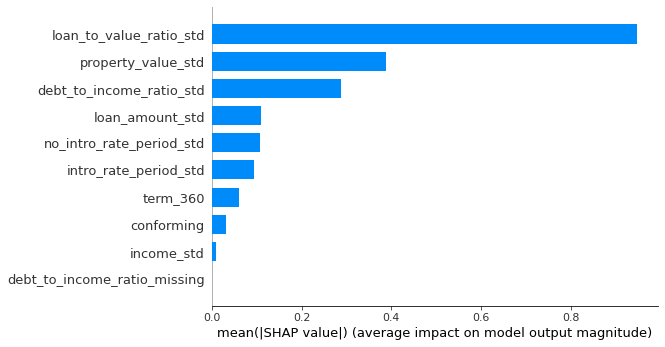

In [24]:
shap_contribs = shap_contribs_matrix[:,:-1] # remove constant intercept column
shap.summary_plot(shap_contribs, x_names, plot_type='bar', title='Variable Importance: MGBM') # use shap package for nice bar plot

### GBM

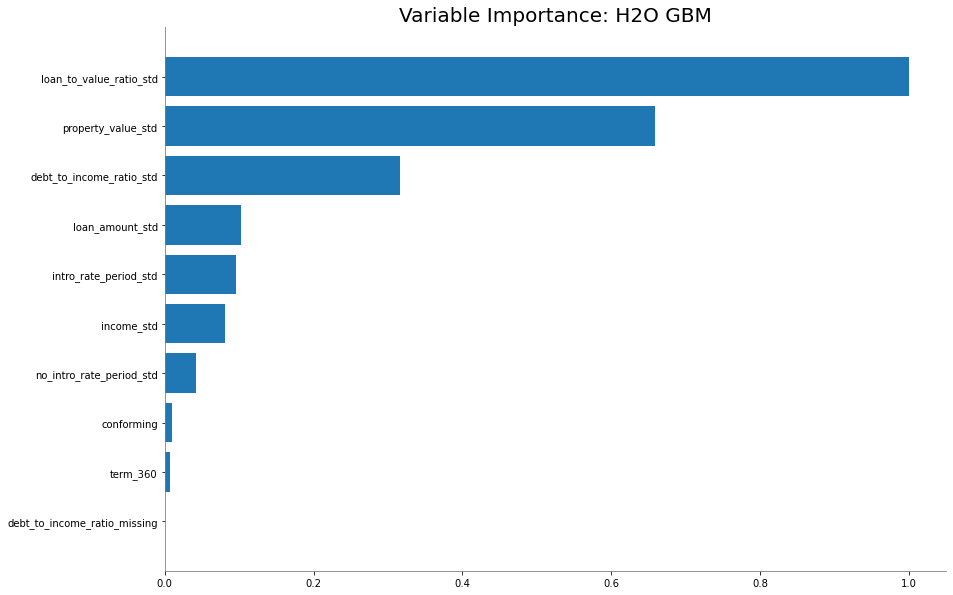

In [26]:
gbm_h2o.varimp_plot()

## Calculate and Plot Local Feature Importance.

In [46]:
from rmltk import explain

ImportError: cannot import name 'explain' from 'rmltk' (unknown location)

In [ ]:
# merge MGBM predictions onto test data
mgbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             best_gbm.predict(h2o.H2OFrame(valid))['1.0'].as_data_frame()],
                            axis=1)

# rename yhat column
mgbm_yhat_valid = mgbm_yhat_valid.rename(columns={'1.0':'p_high_priced'})

# find percentiles of predictions
mgbm_percentile_dict = explain.get_percentile_dict('p_high_priced', mgbm_yhat_valid, 'ID')

# display percentiles dictionary
# key=percentile, val=ID
mgbm_percentile_dict

In [49]:
local_coef_dict = {10: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names),
                   50: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names),
                   90: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names)}

In [ ]:
# Utility function for selecting percentiles

def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict

In [ ]:
# Score validation data with model

best_gbm_phat = pd.DataFrame(shap_contribs_hf, columns=['phat'])
best_gbm_phat = pd.concat([valid.reset_index(drop=True), best_gbm_phat], axis=1)
best_gbm_phat.head()

In [67]:
shap_contribs_hf

term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,BiasTerm
0.026583,0.00998619,-0.000401435,0.0898872,0.904778,-0.0699677,0.059275,0.448239,0.00665863,0.30928,-2.92873
0.0265381,0.00993569,-0.000386817,0.0584344,1.09658,-0.0714416,0.059366,0.1702,0.0094042,0.334736,-2.92873
0.0326665,0.0245256,-0.00039982,-0.0780973,-0.151257,-0.077142,0.0626242,-0.412621,0.00577288,-0.0186056,-2.92873
0.0317279,0.0165319,-0.00039512,0.00853799,-1.03646,-0.086346,0.0623541,-0.0632519,0.00501773,0.238495,-2.92873
0.0494444,0.0284307,-0.00041849,-0.0481507,-1.16624,-0.0949318,0.0663659,-0.433512,-0.00971625,-0.440298,-2.92873
0.018999,0.00904145,-0.000403274,0.172108,1.65928,-0.0631314,0.0570998,1.2539,0.00589507,0.872873,-2.92873
0.0308402,0.0289285,-0.000404273,-0.0195632,-1.27976,-0.0976158,0.0643524,-0.365755,-0.00336719,0.171214,-2.92873
0.0365688,0.0226845,-0.000423188,-0.209688,0.928436,-0.0741334,0.0635415,-0.440688,-0.0261167,-0.554075,-2.92873
0.0308026,0.0184859,-0.000409229,0.0309032,-0.265004,-0.068511,0.0601105,0.420468,0.00358265,-0.0390398,-2.92873
0.0292749,0.0154347,-0.000395578,-0.0916718,0.969213,-0.0651837,0.0598013,-0.166138,0.0160036,-0.0753012,-2.92873


In [ ]:
best_gbm_percentiles = get_percentile_dict('phat', best_gbm_phat, 'row_id')
for key in sorted(best_gbm_percentiles.keys()):
    print(str(key) + ': ' + str(best_mxgb_percentiles[key]))

C:\Users\minhyekim\Anaconda3\lib\site-packages\h2o\explanation\_explain.py:2599: UserWarning: No model with variable importance. Selecting all features to explain.
  warnings.warn("No model with variable importance. Selecting all features to explain.")


# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

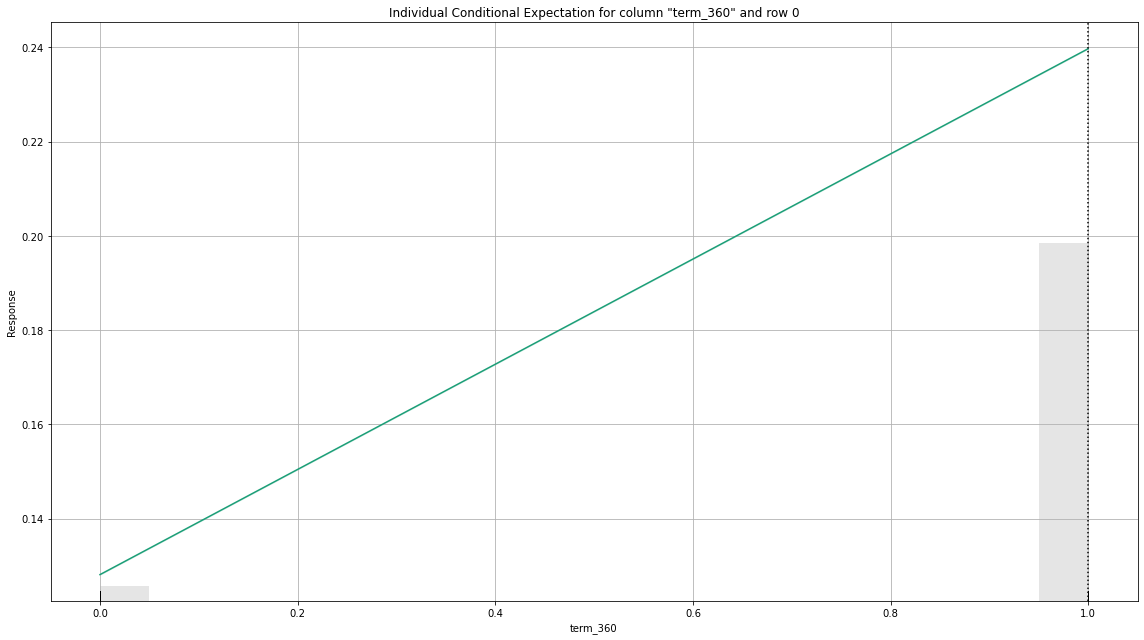

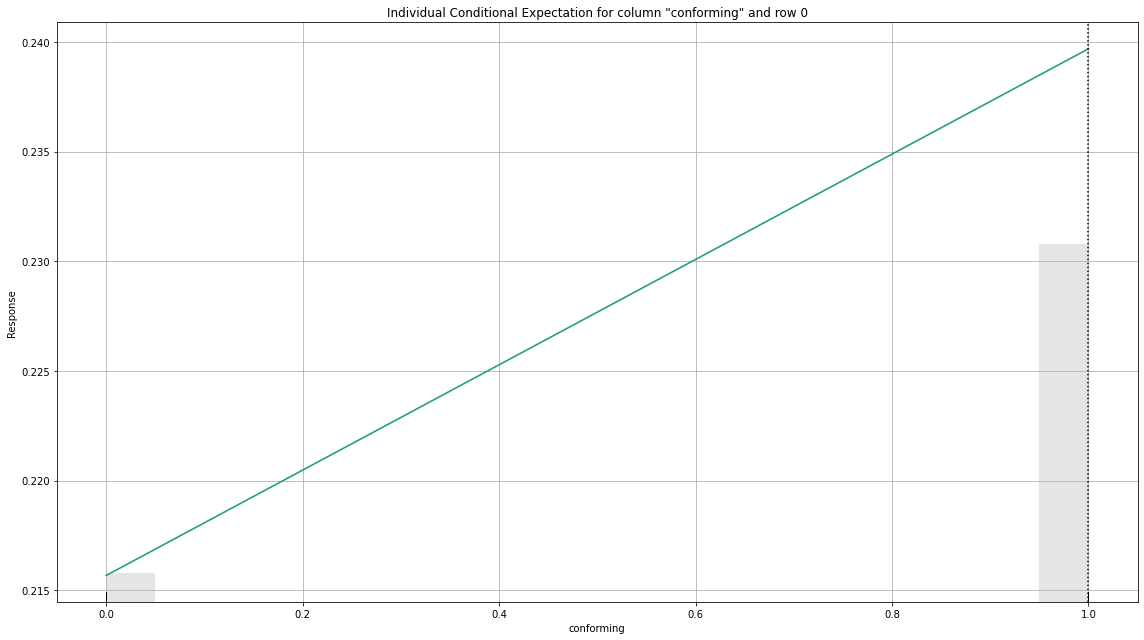

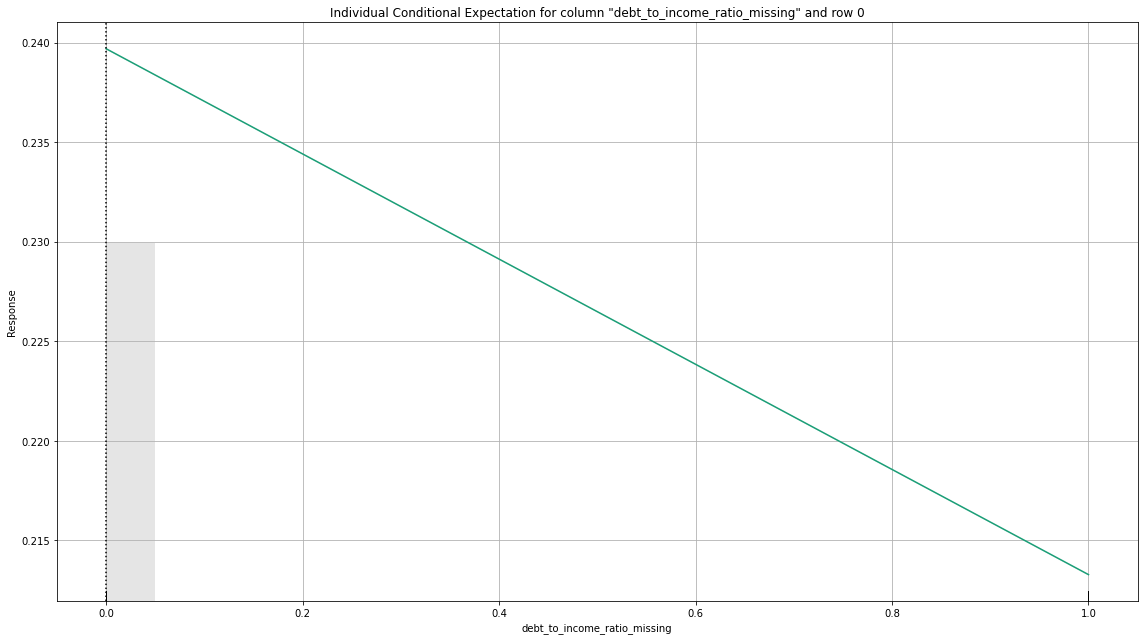

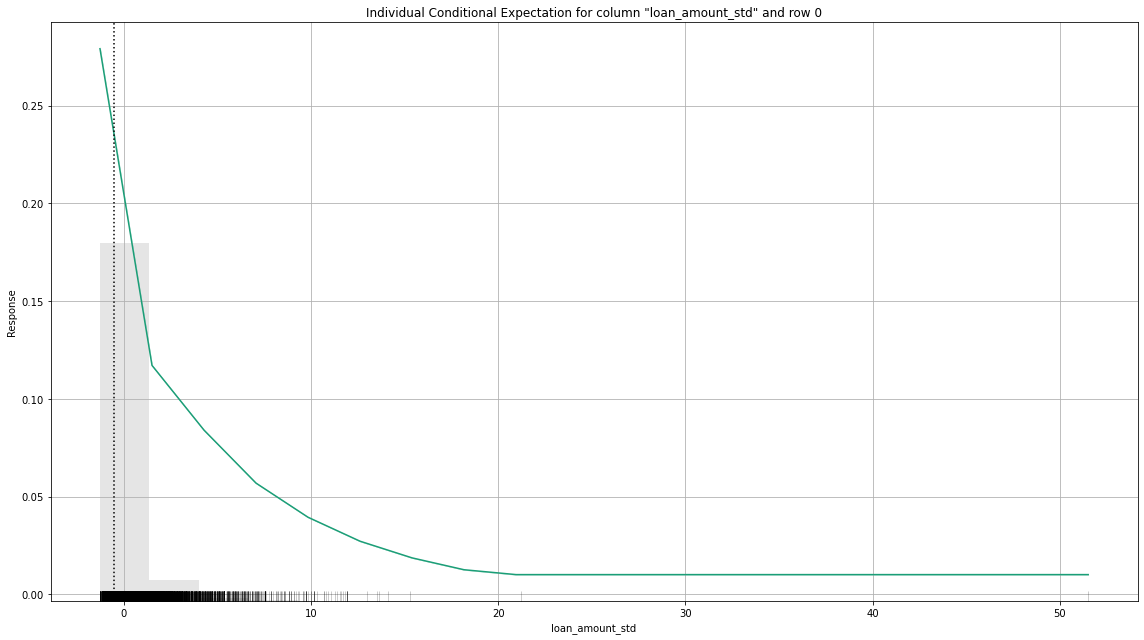

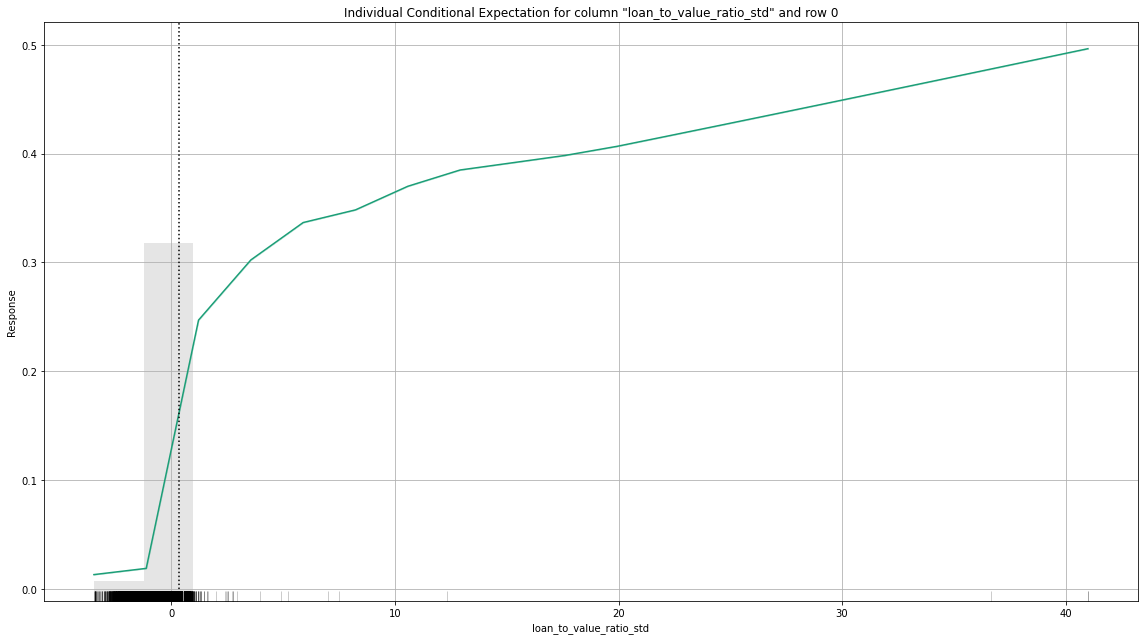

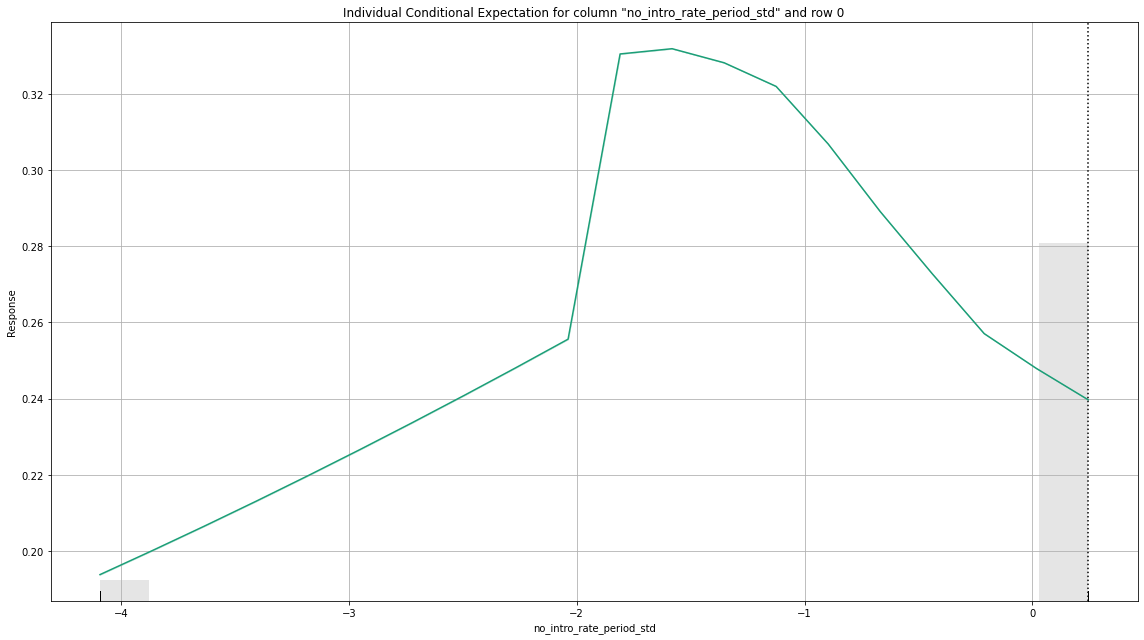

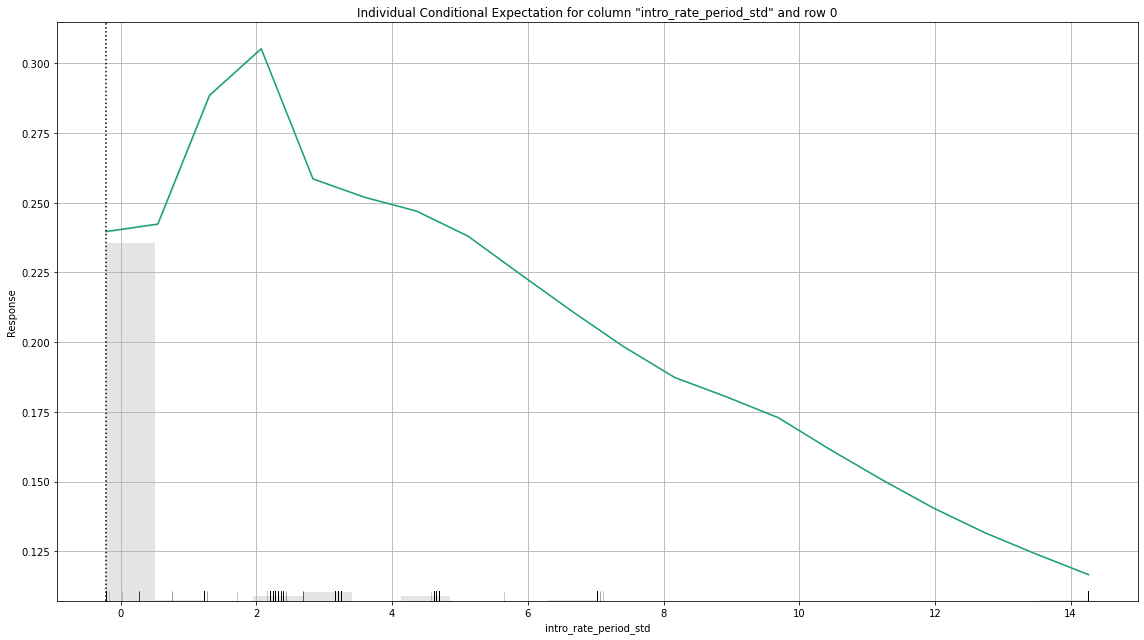

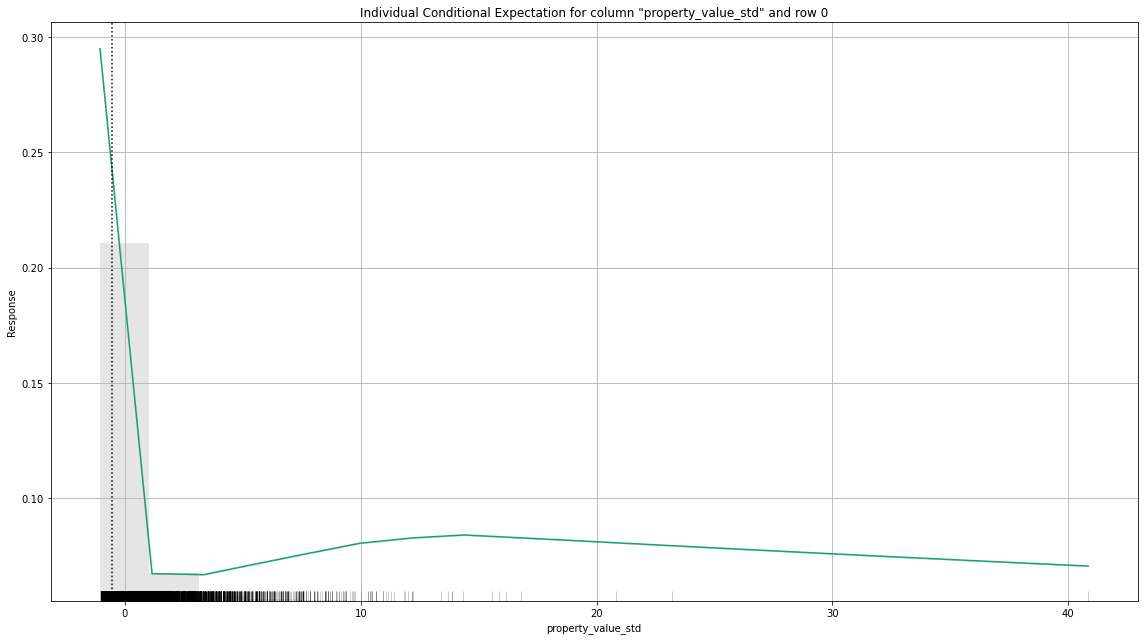

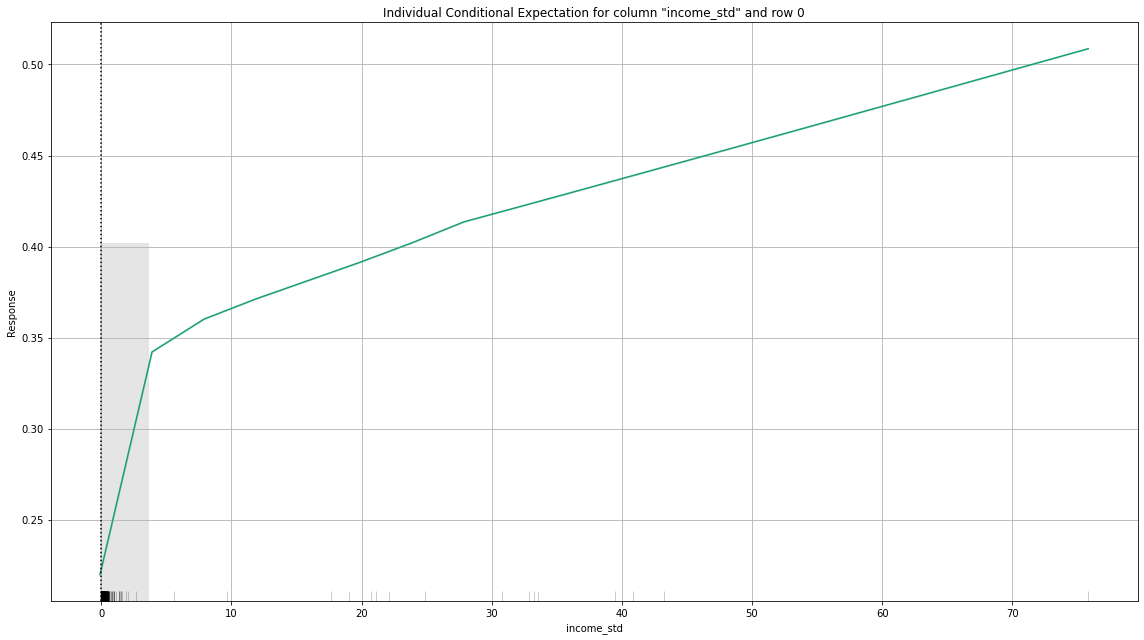

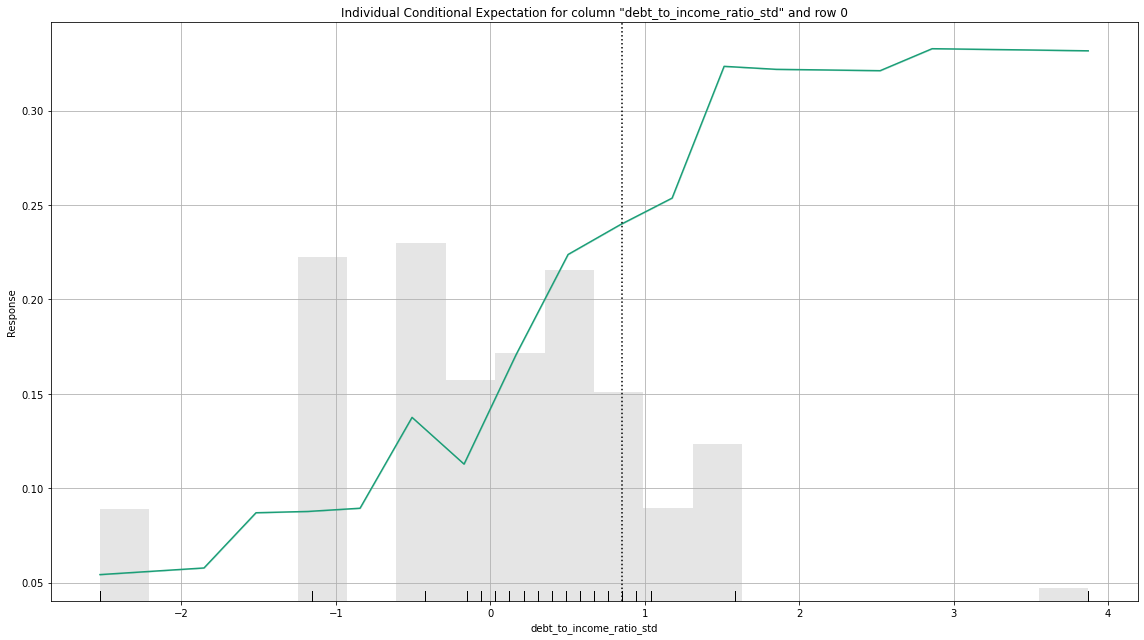

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

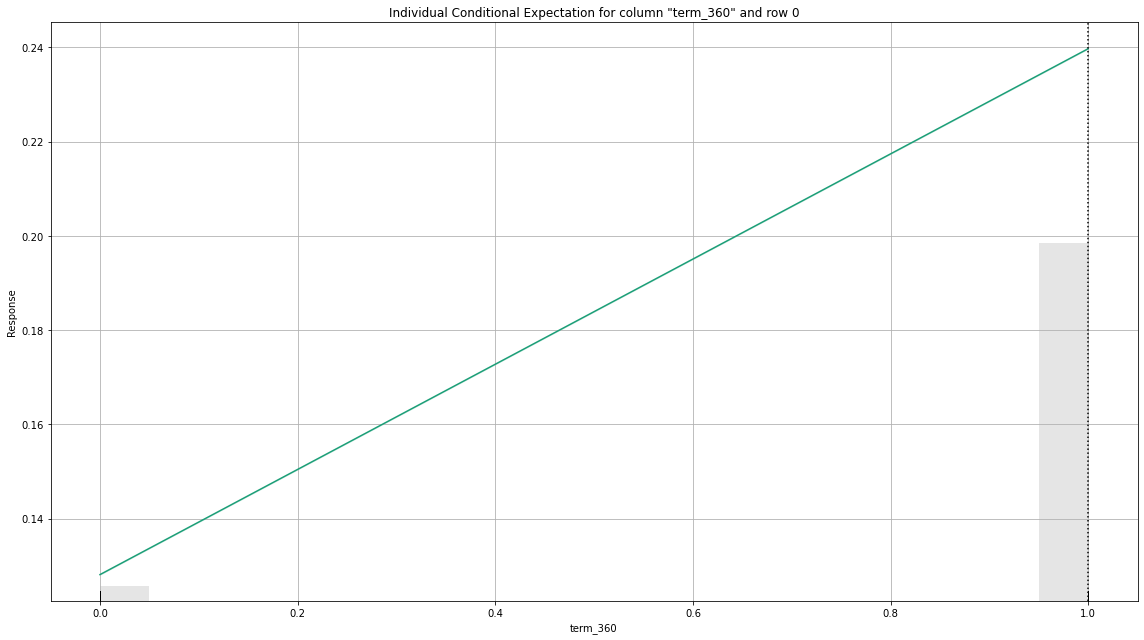

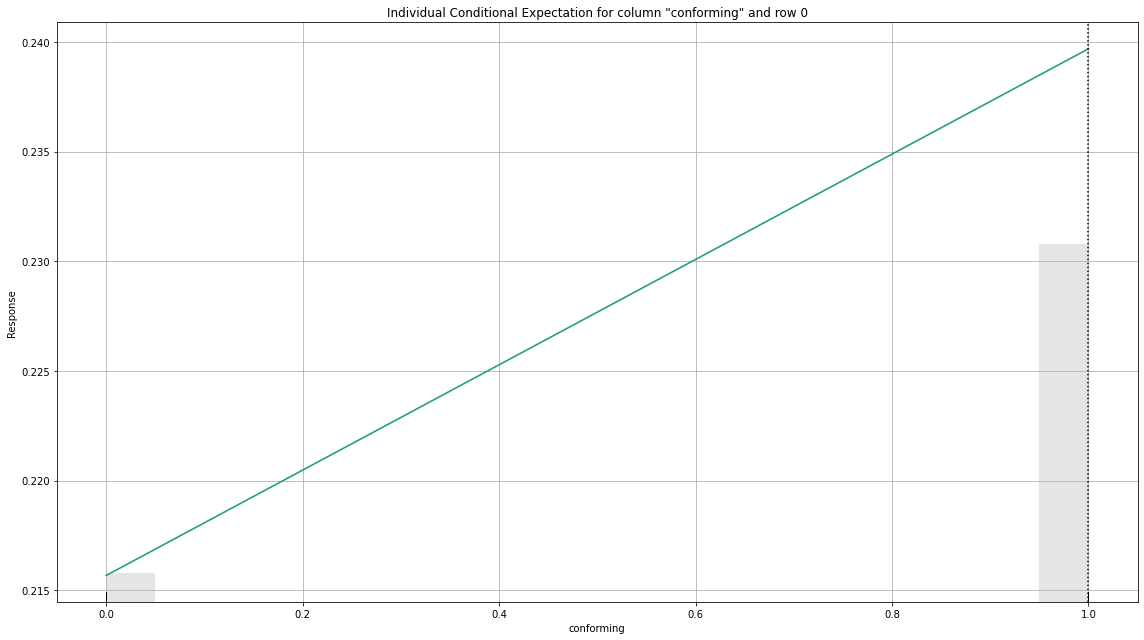

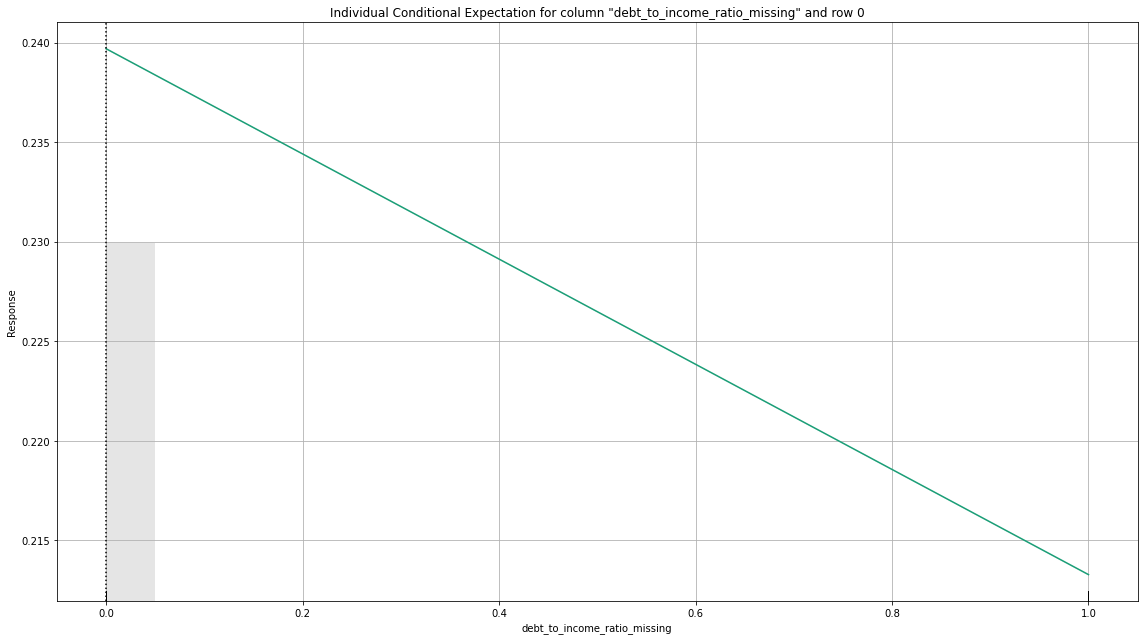

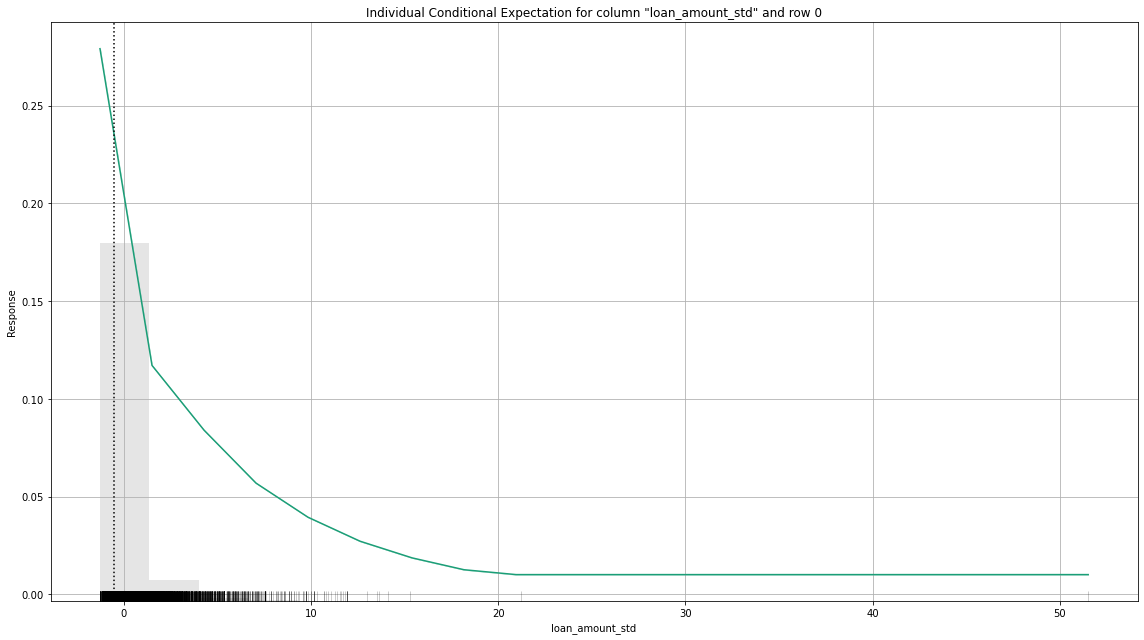

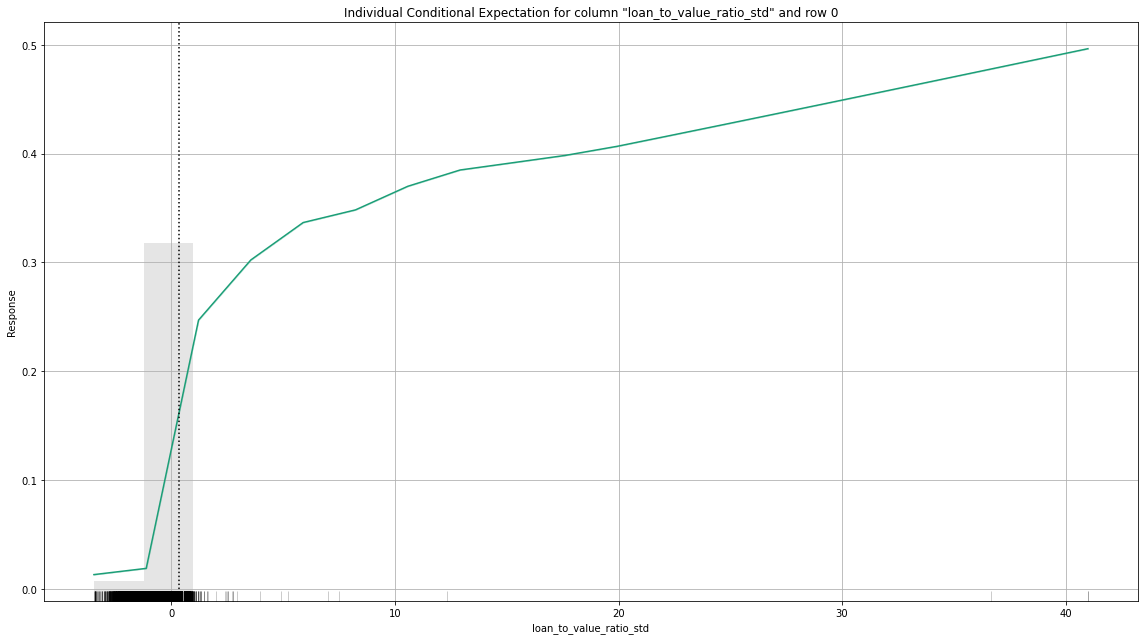

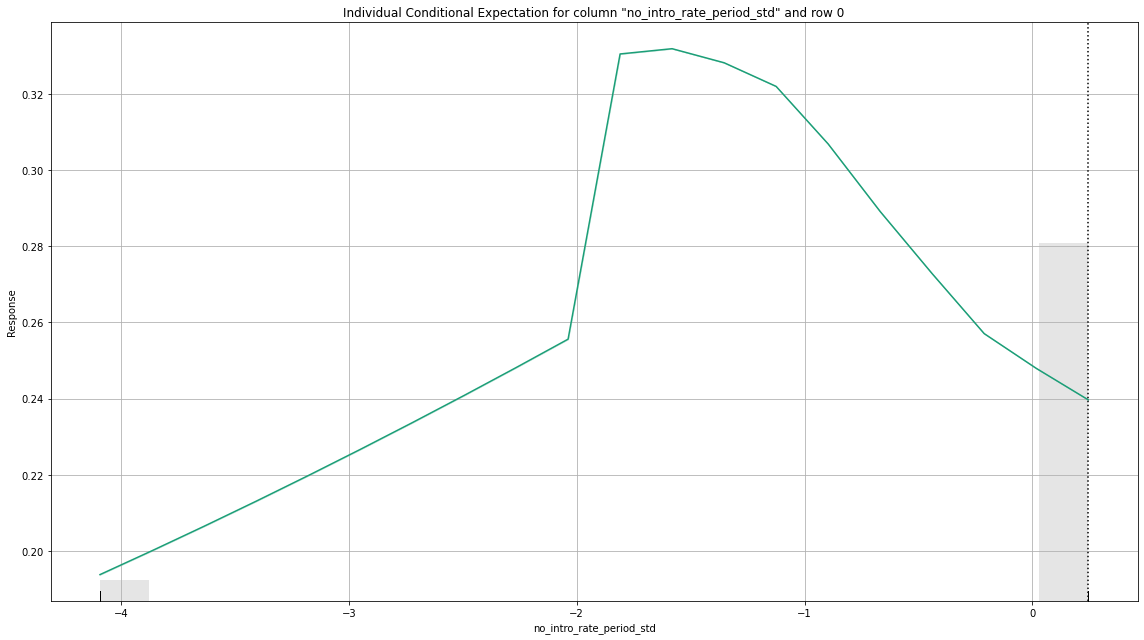

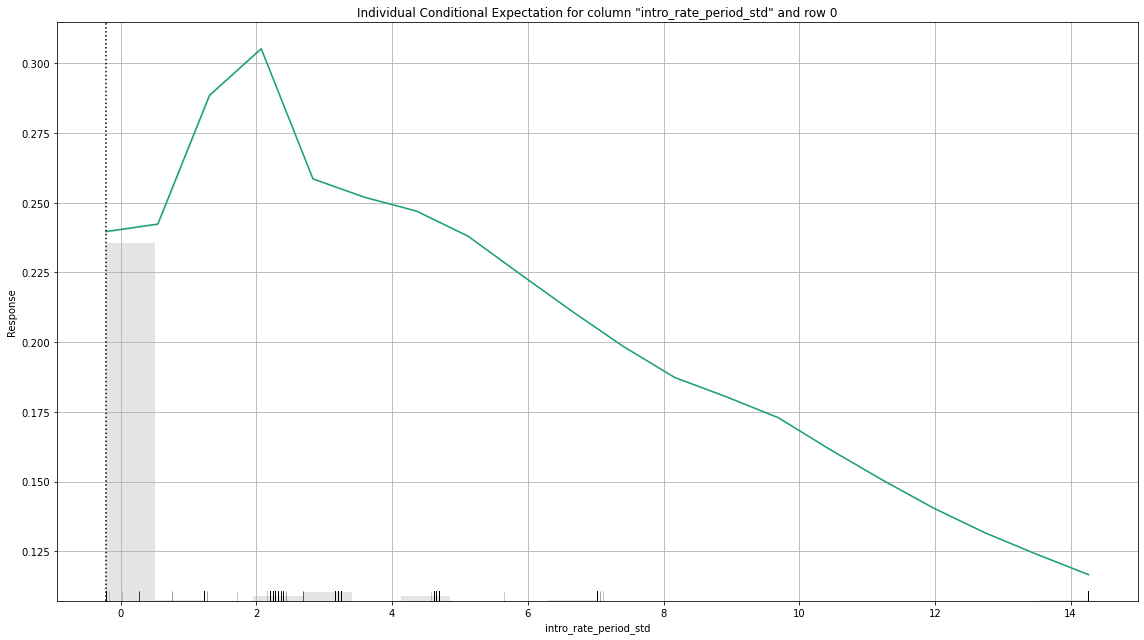

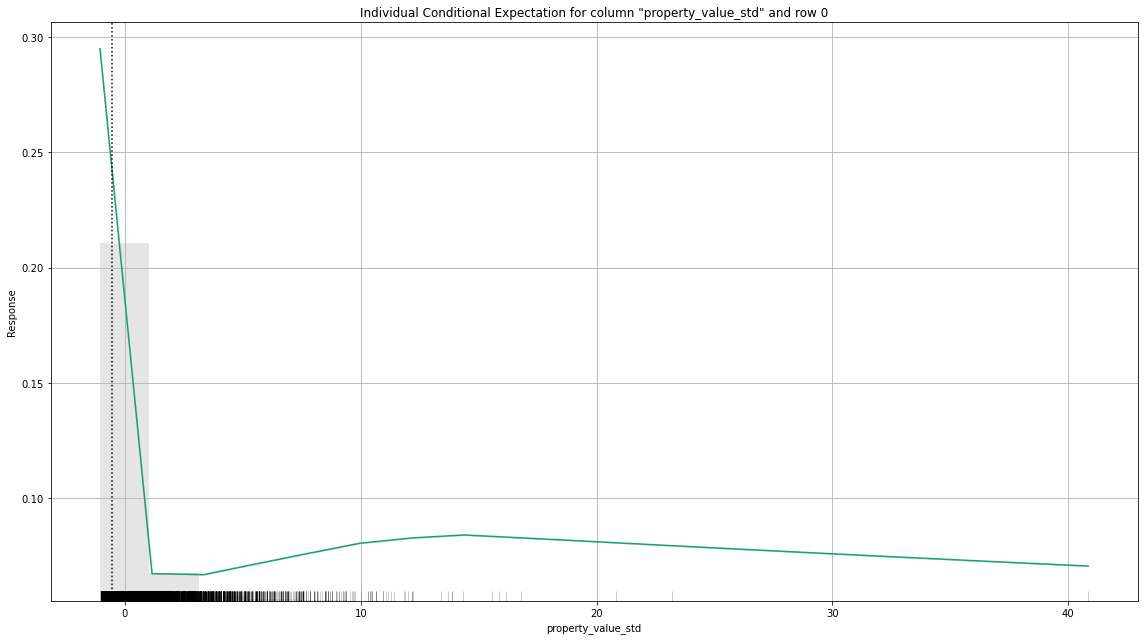

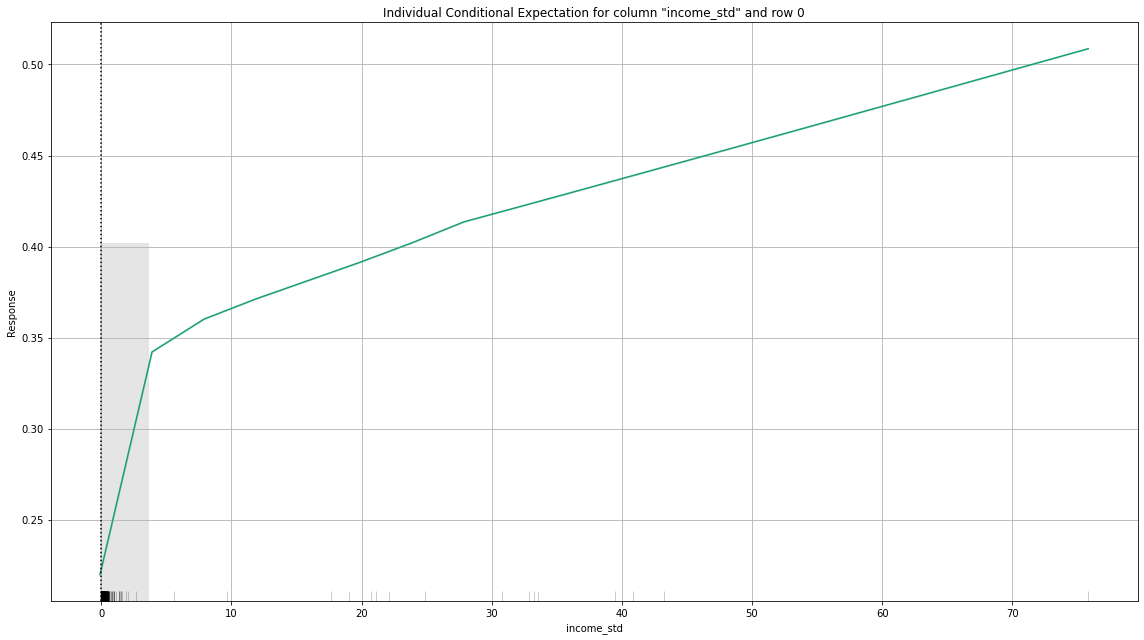

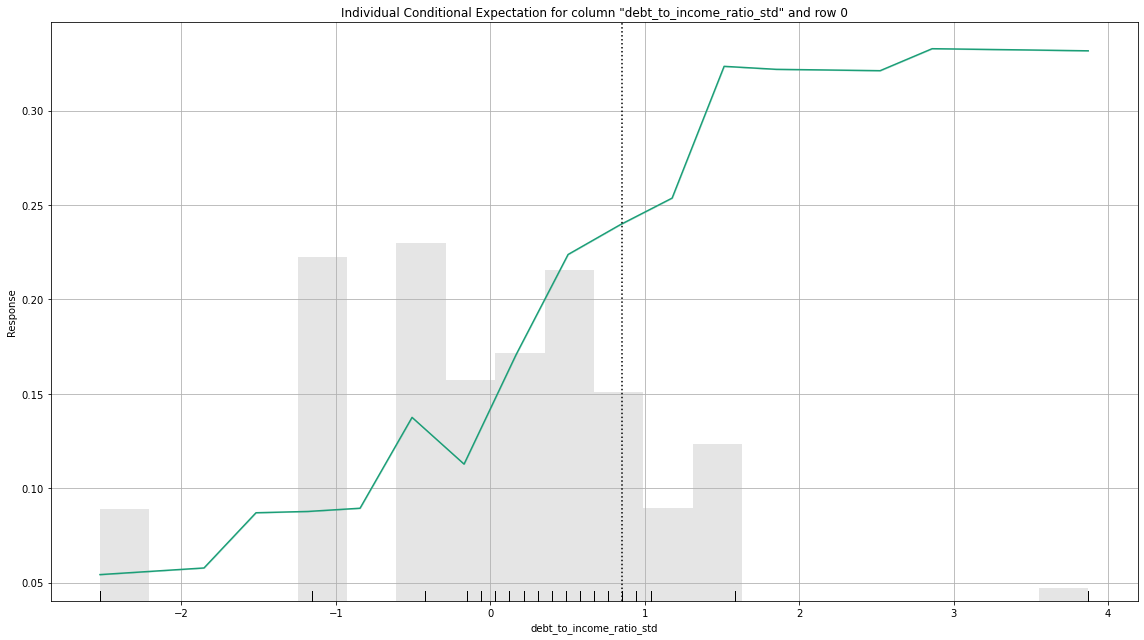

In [15]:
# Explain first row
ensenble_h2o.explain_row(hvalid, row_index=0)


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

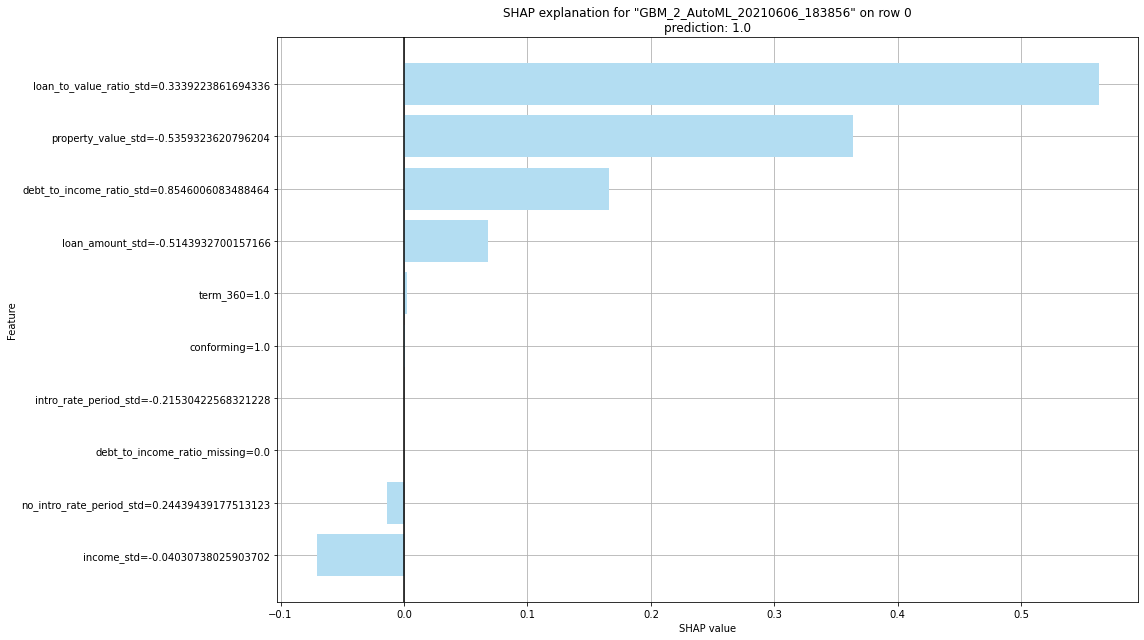

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

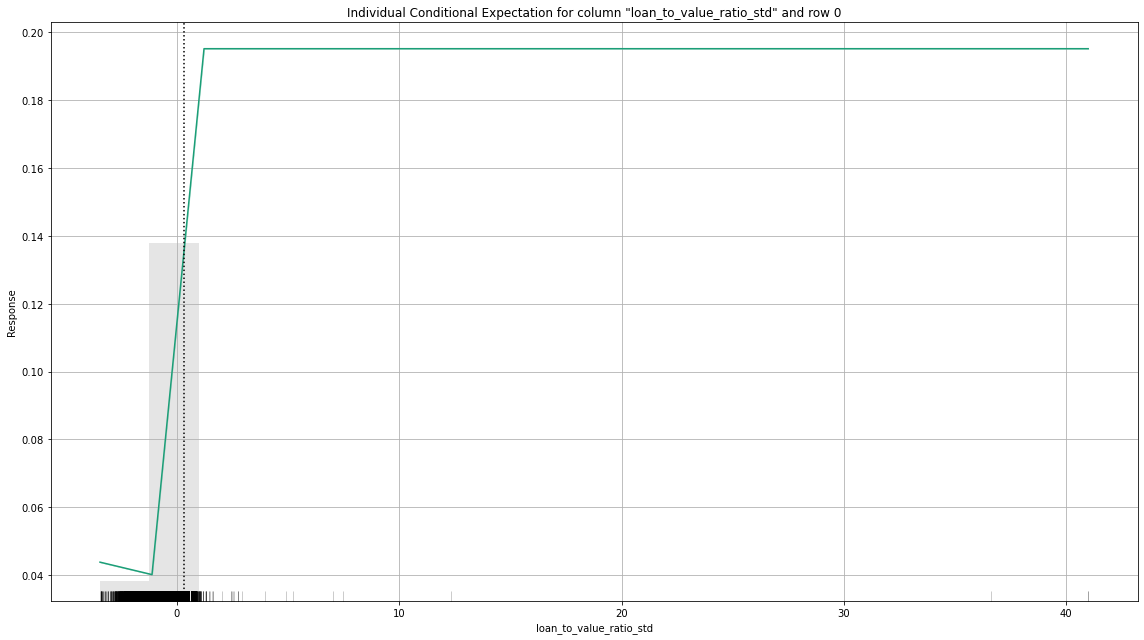

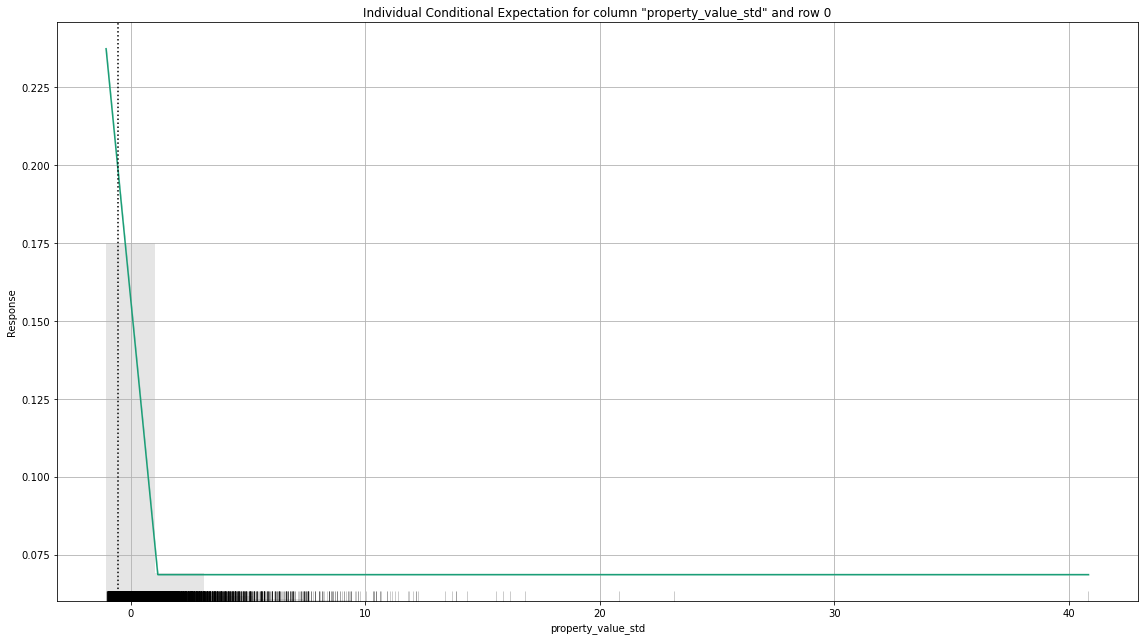

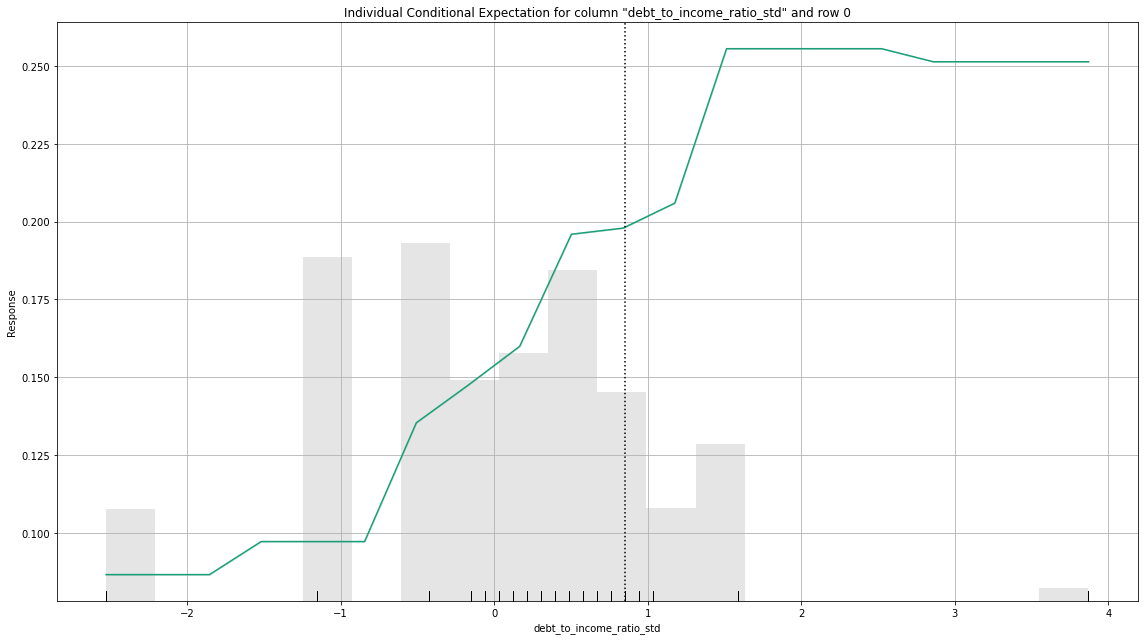

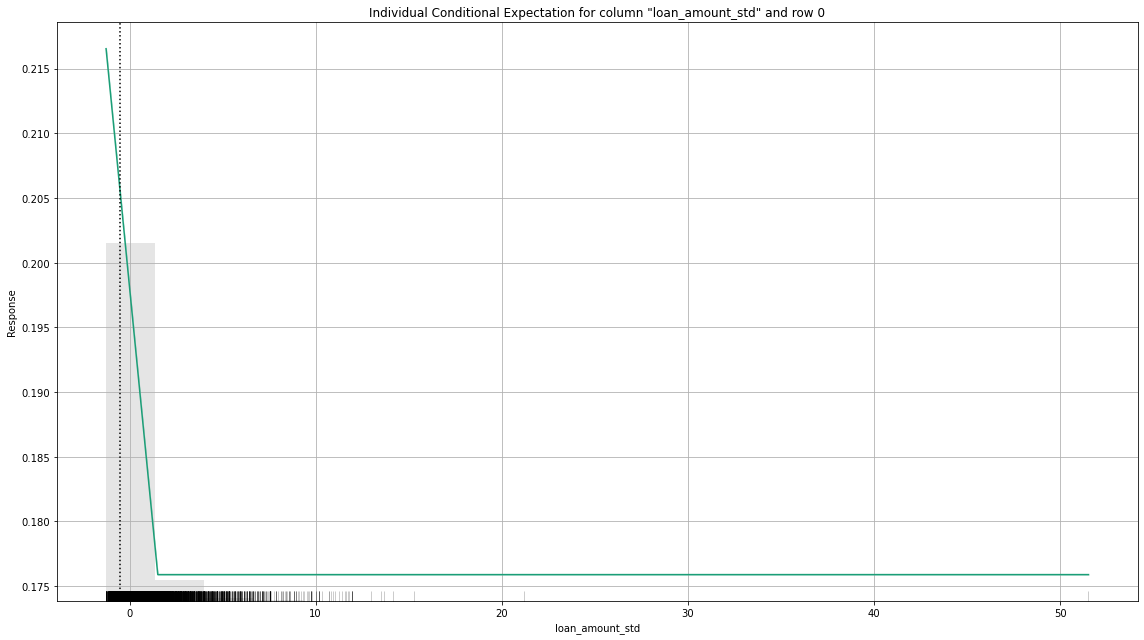

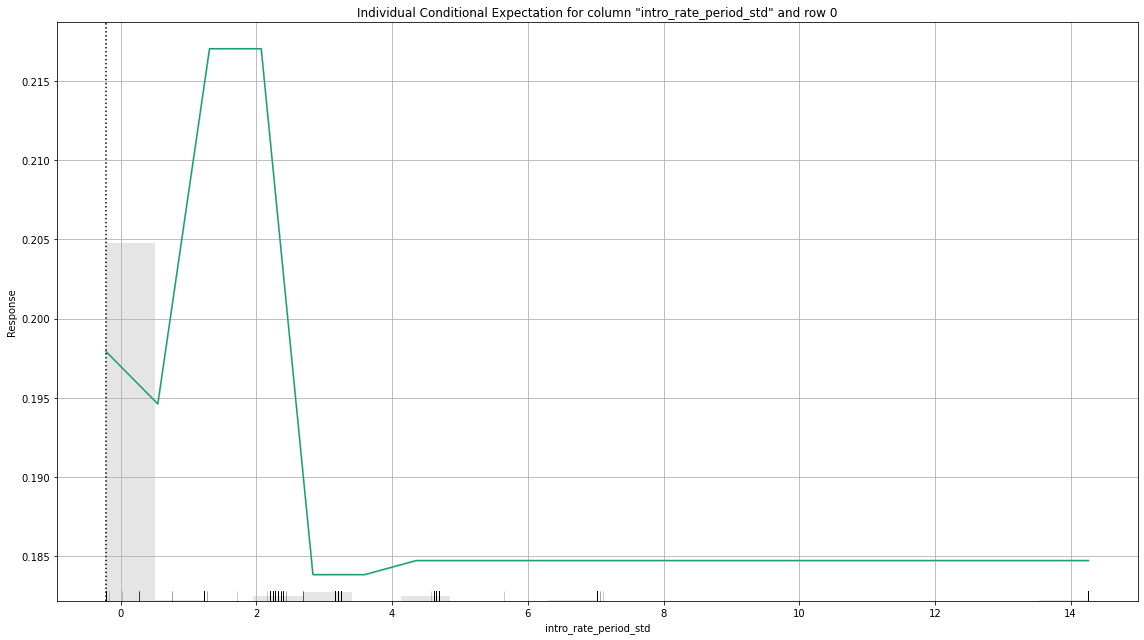

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

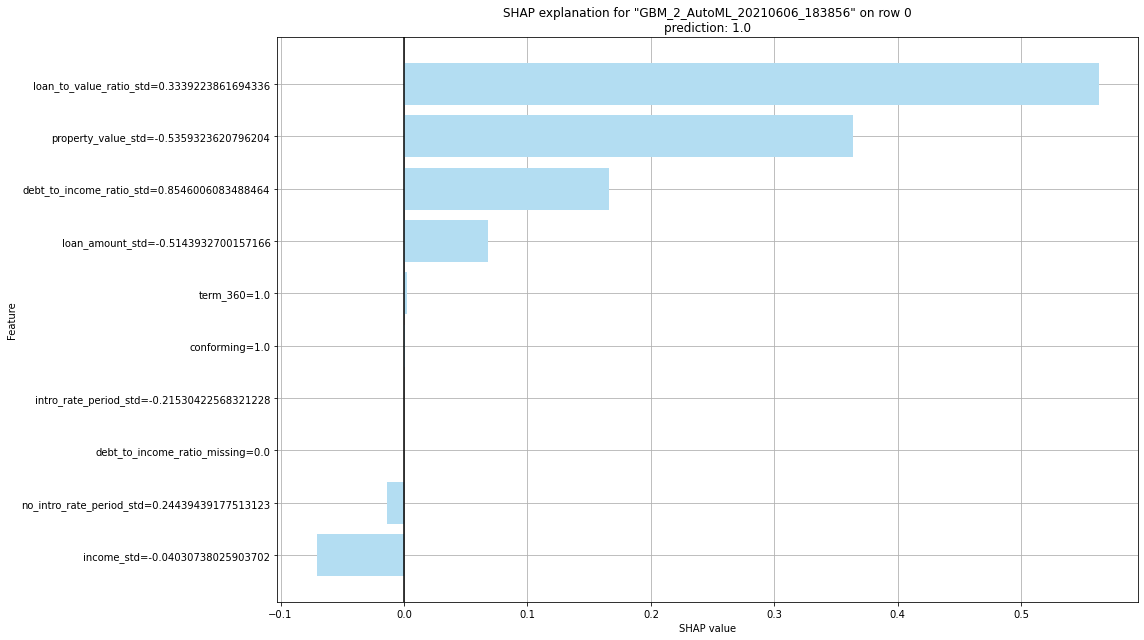

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

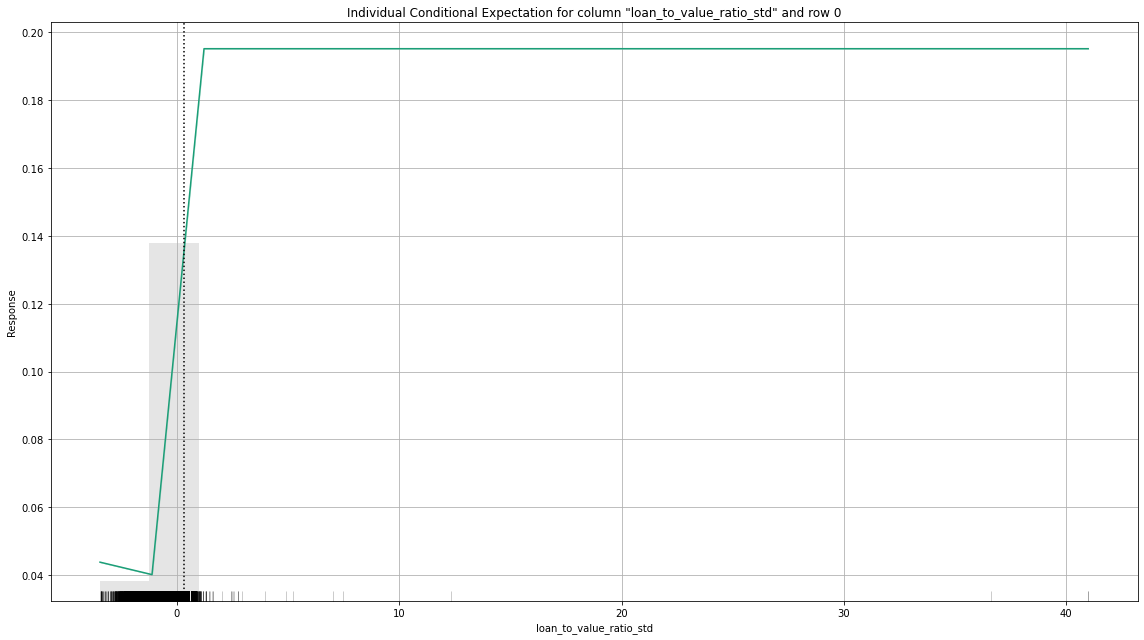

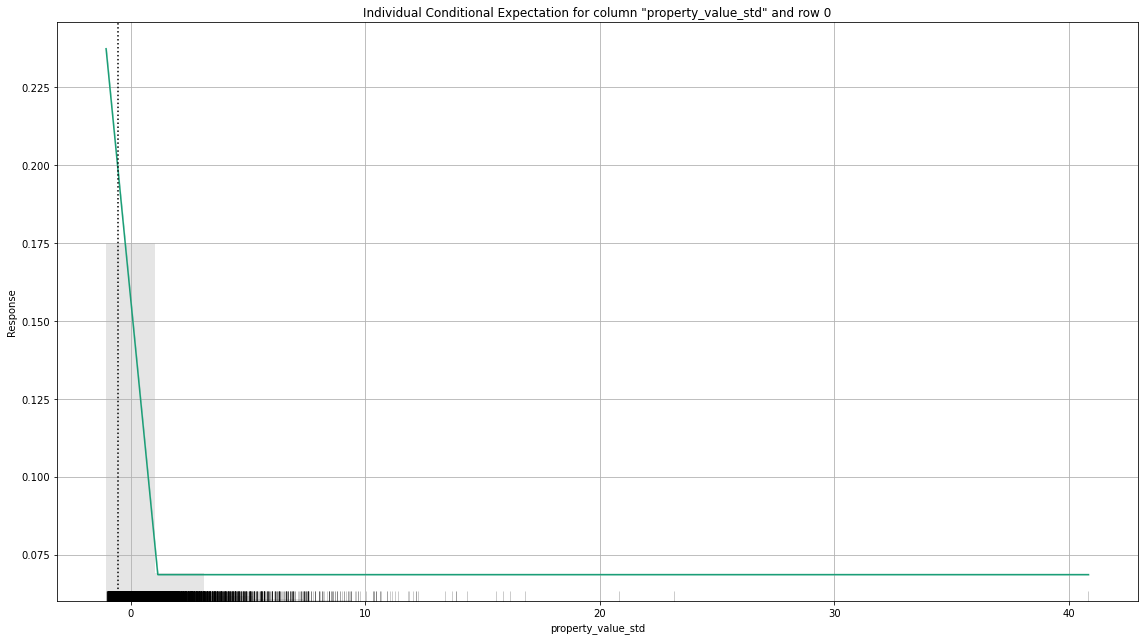

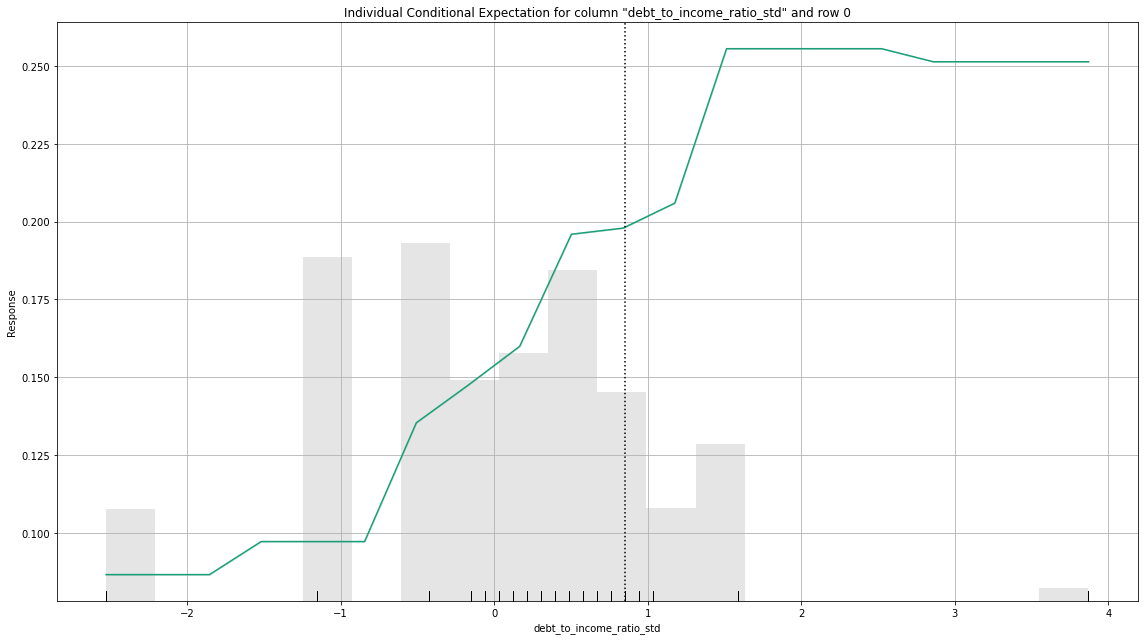

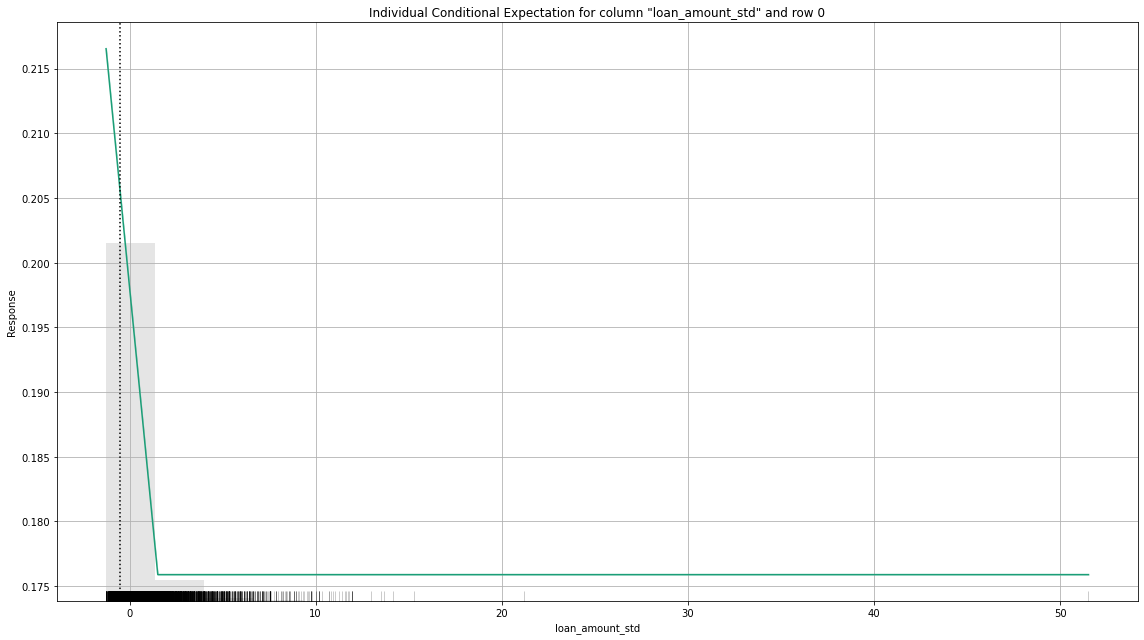

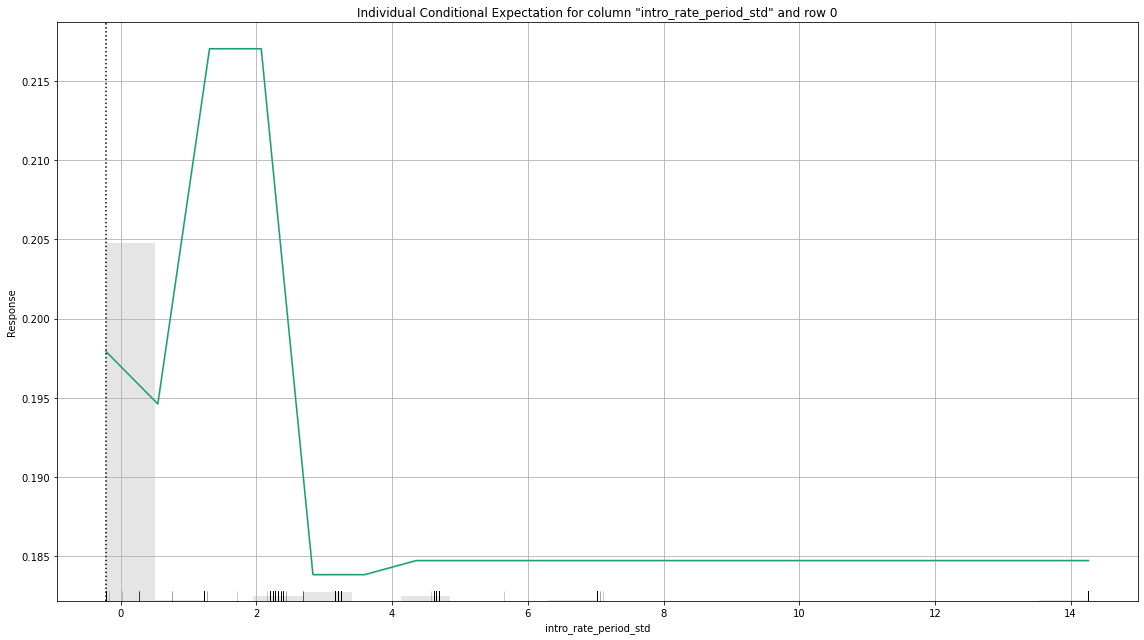

In [20]:
# Explain first row 
gbm_h2o.explain_row(hvalid, row_index=0)

## Calculate and Plot Feature Behavior.

### MGBM

In [33]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'mgbm':
        temp_df['partial_dependence'] = best_gbm.predict(h2o.H2OFrame(temp_df))['1.0'].as_data_frame()
    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

In [34]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:
    
    print('Calculating partial dependence for %s ...' % name)
    
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'mgbm'])
    first_pd = par_dep(name, valid[x_names], best_gbm, 'mgbm')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['mgbm'] = first_pd['partial_dependence']
    
    
print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Done.
Partial dependence calculated in 770.33 s.


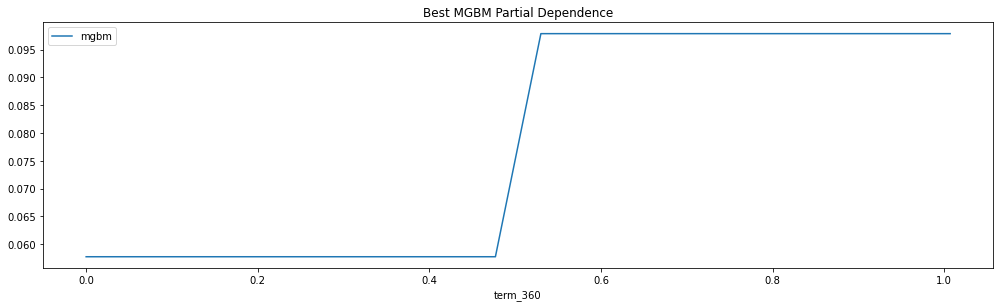

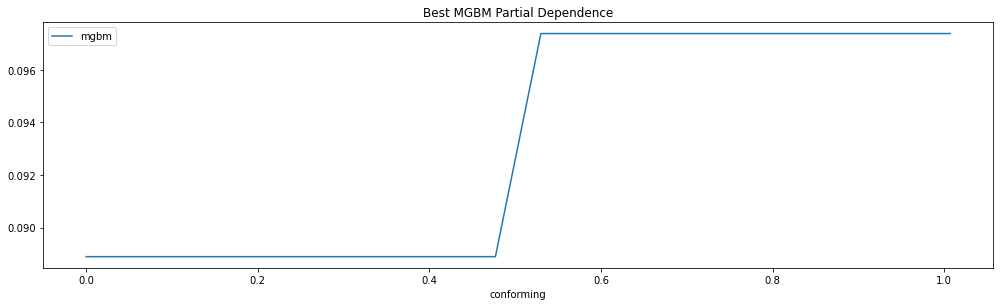

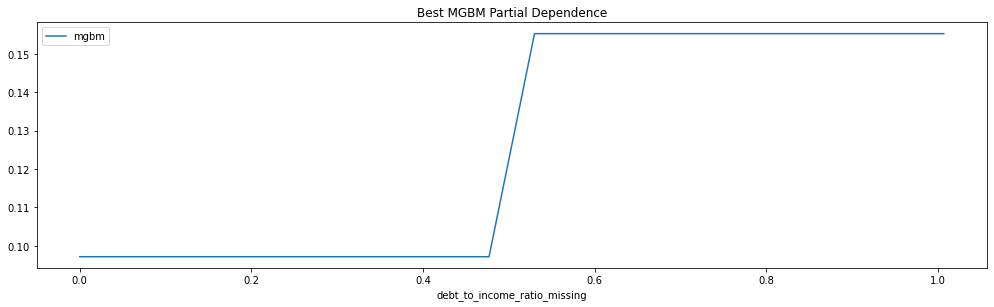

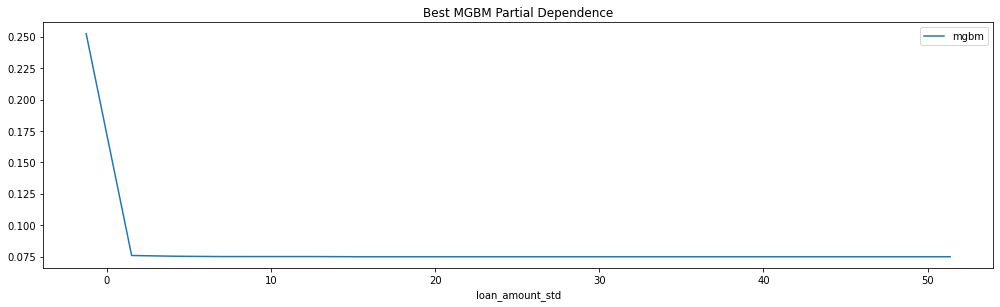

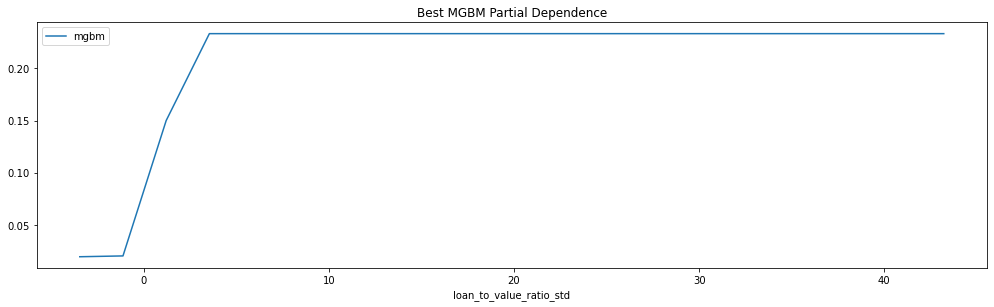

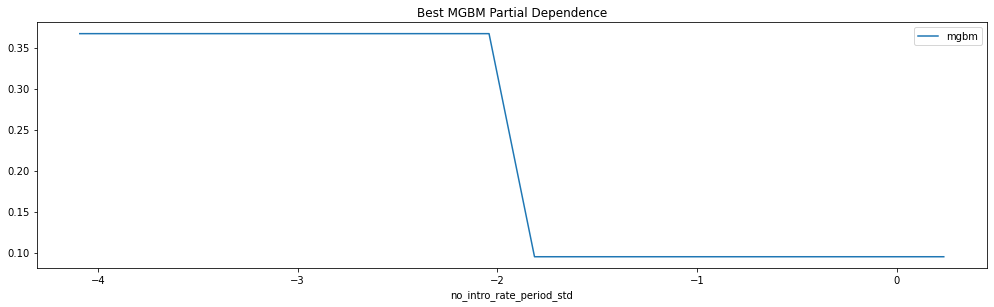

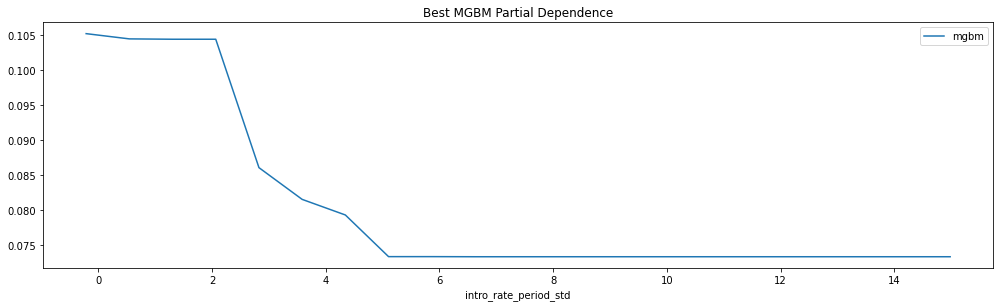

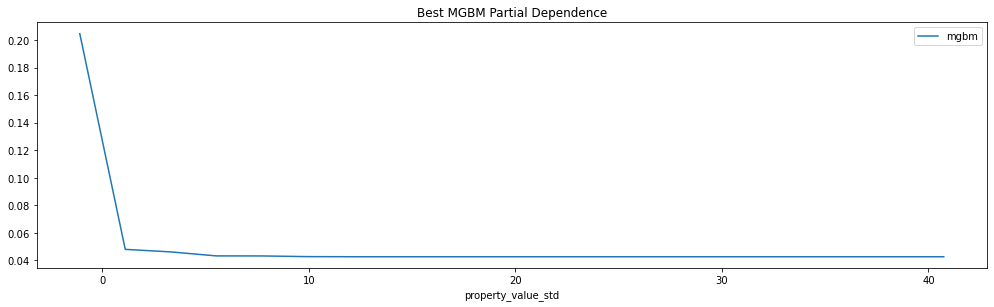

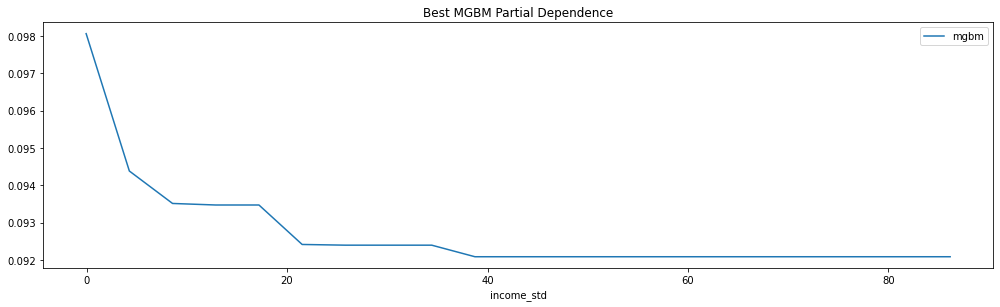

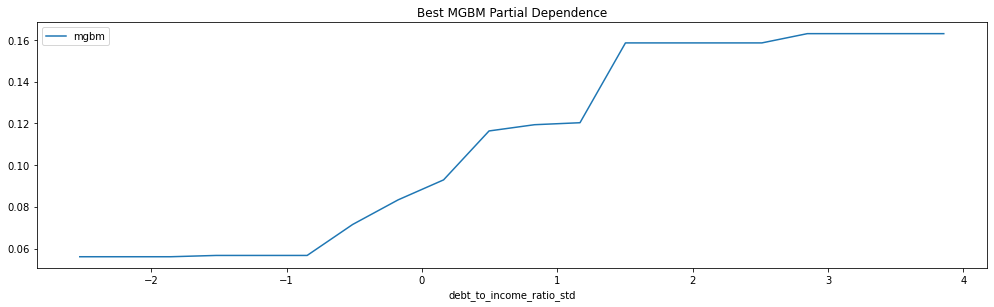

In [35]:
# loop through names to calculate par dep 
for name in x_names:
    
    # init 3-pane plot
    fig, (ax0) = plt.subplots(ncols=1, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)
  
    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='mgbm', ax=ax0, title='Best MGBM Partial Dependence')
    ax0.set_xlabel(name)
   

### GBM

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_2_AutoML_20210606_183856


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16635438877901423: 


,,0.0,1.0,Error,Rate
0,0.0,83042.0,18284.0,0.1804,(18284.0/101326.0)
1,1.0,4107.0,6820.0,0.3759,(4107.0/10927.0)
2,Total,87149.0,25104.0,0.1995,(22391.0/112253.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

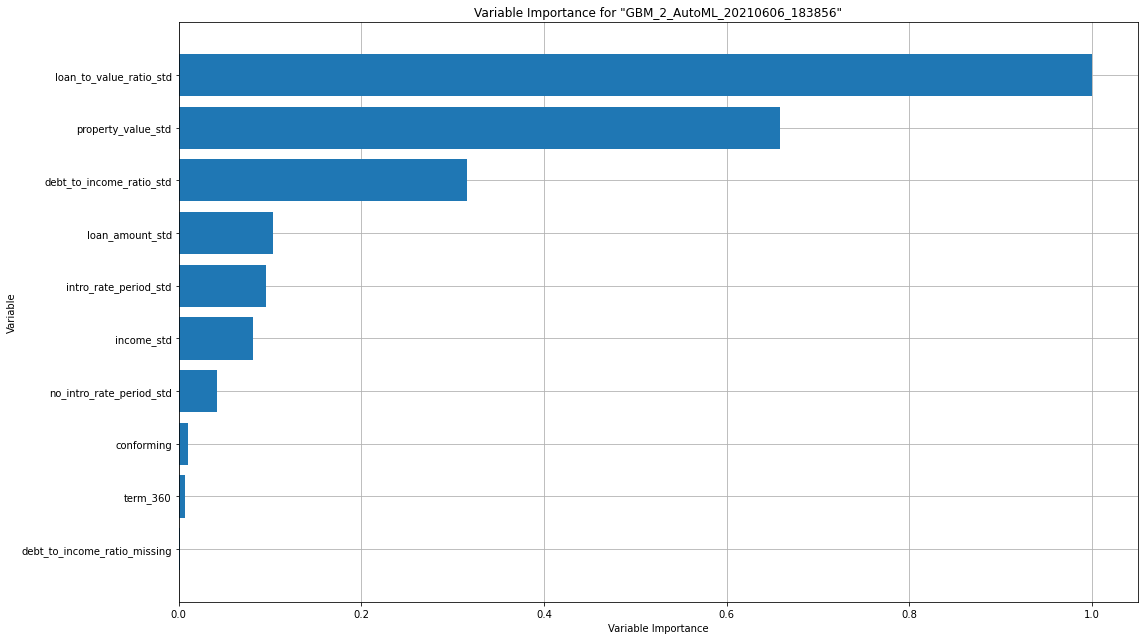

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

invalid value encountered in true_divide


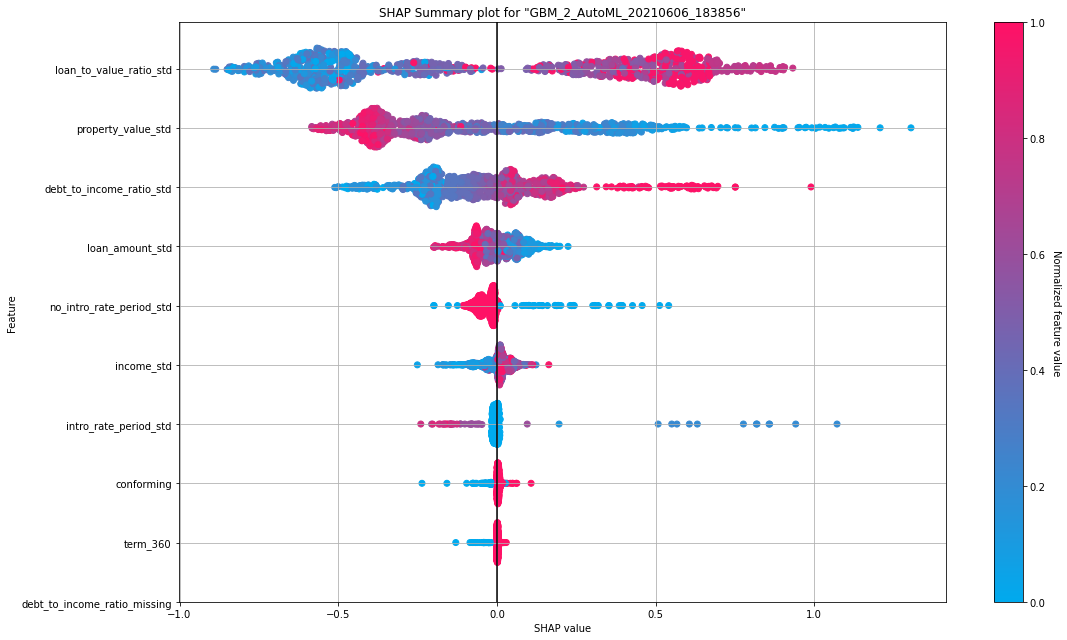

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

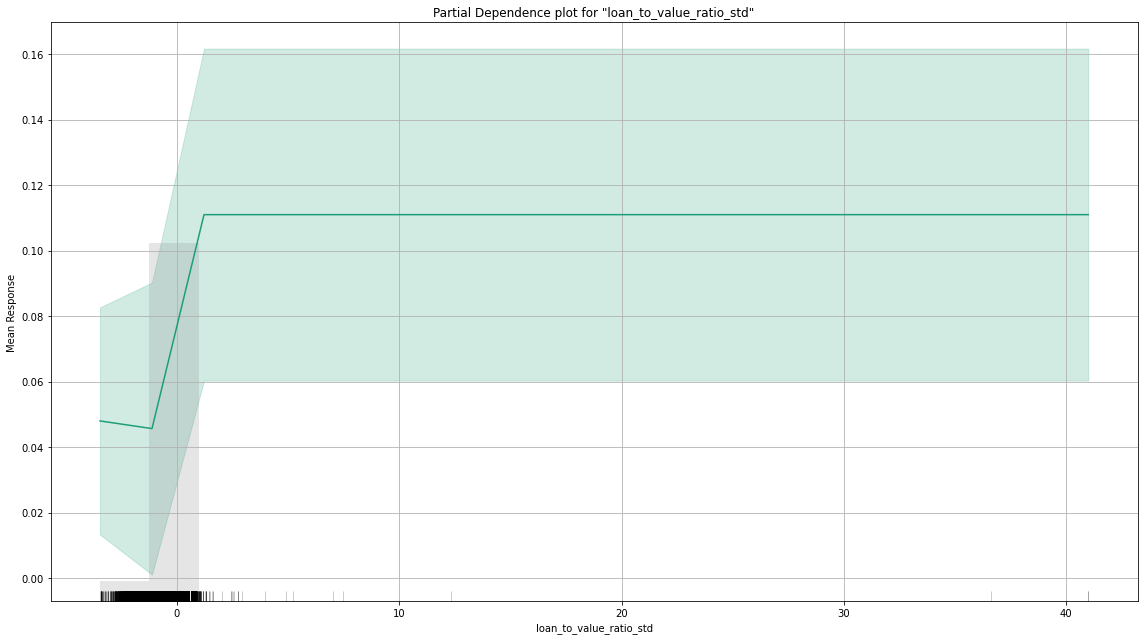

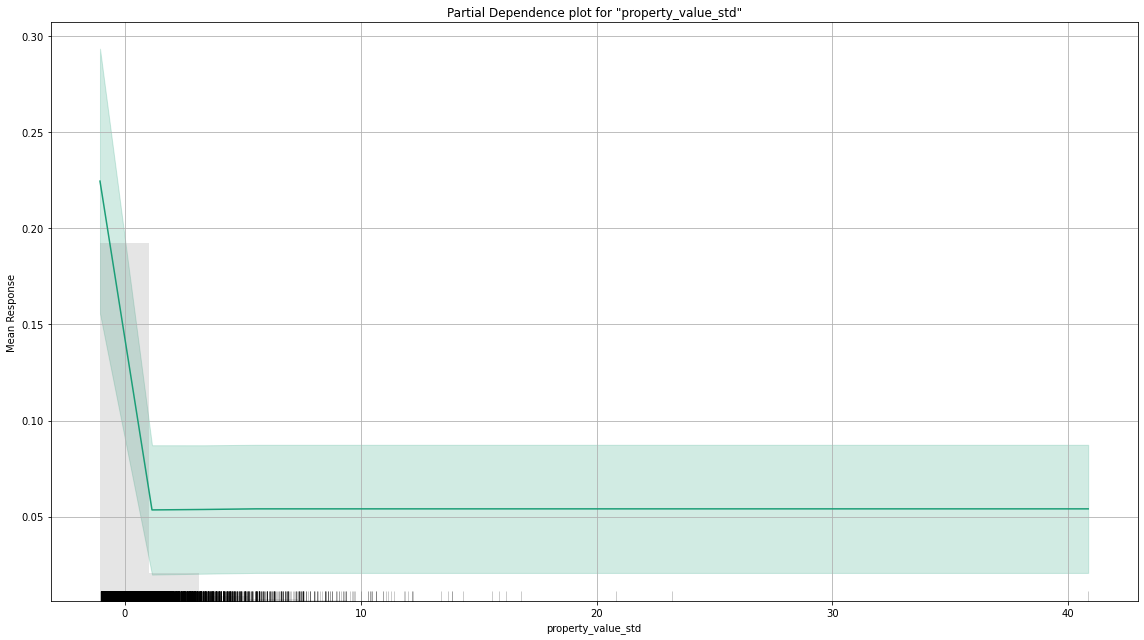

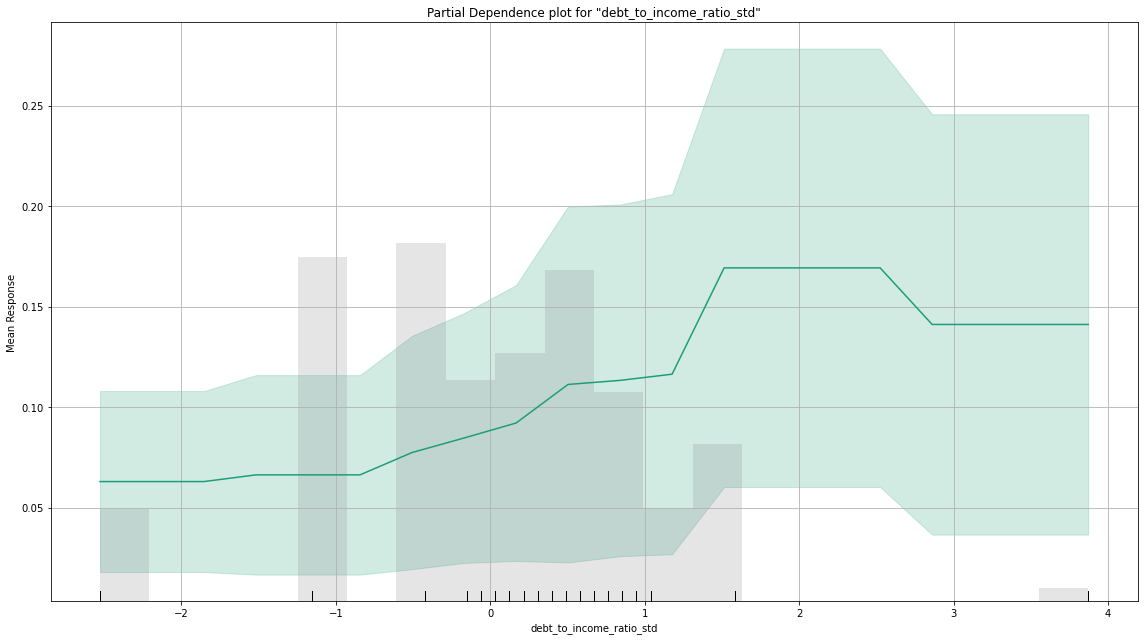

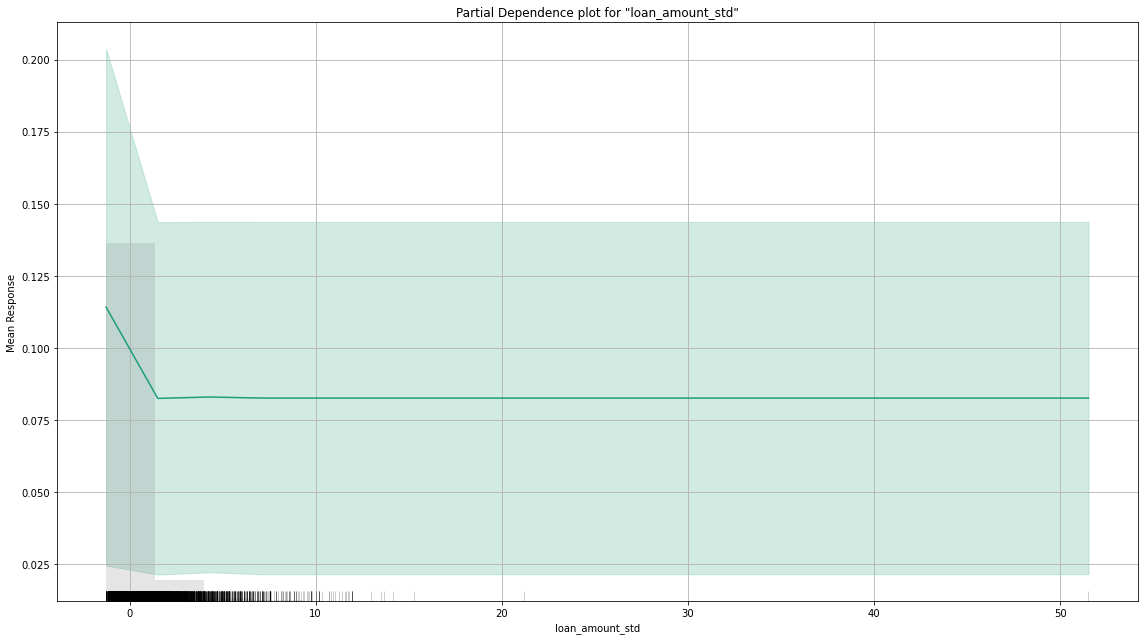

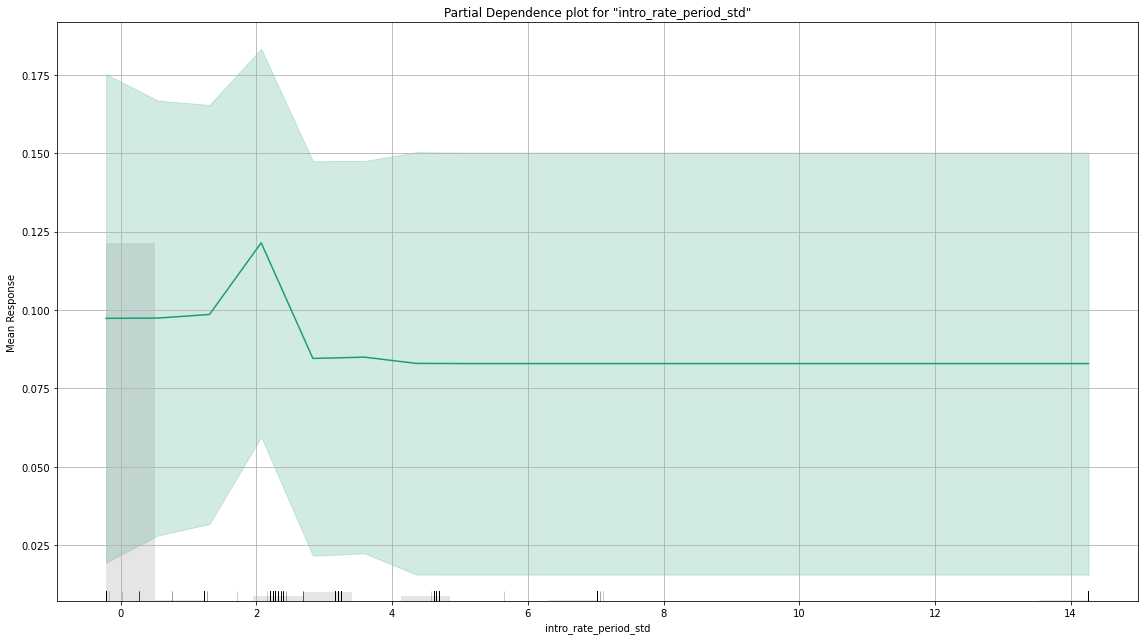

In [42]:
exa_gbm = gbm_h2o.explain(hvalid)

### Ensenble

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_AutoML_20210606_183856


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17808998056654582: 


,,0.0,1.0,Error,Rate
0,0.0,7273.0,1701.0,0.1895,(1701.0/8974.0)
1,1.0,315.0,640.0,0.3298,(315.0/955.0)
2,Total,7588.0,2341.0,0.203,(2016.0/9929.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

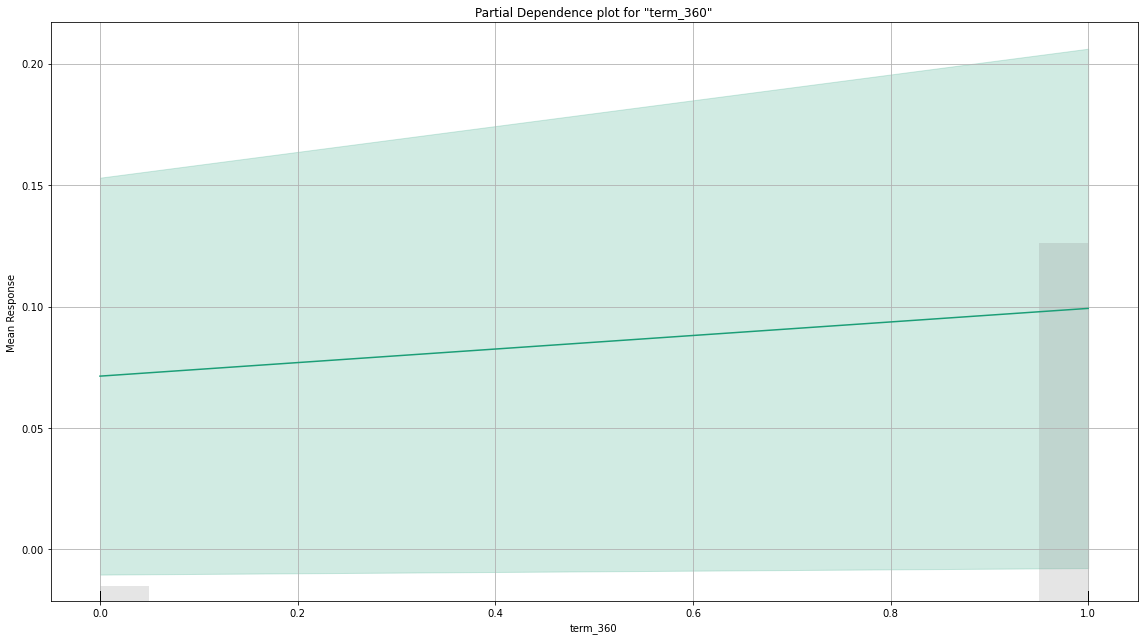

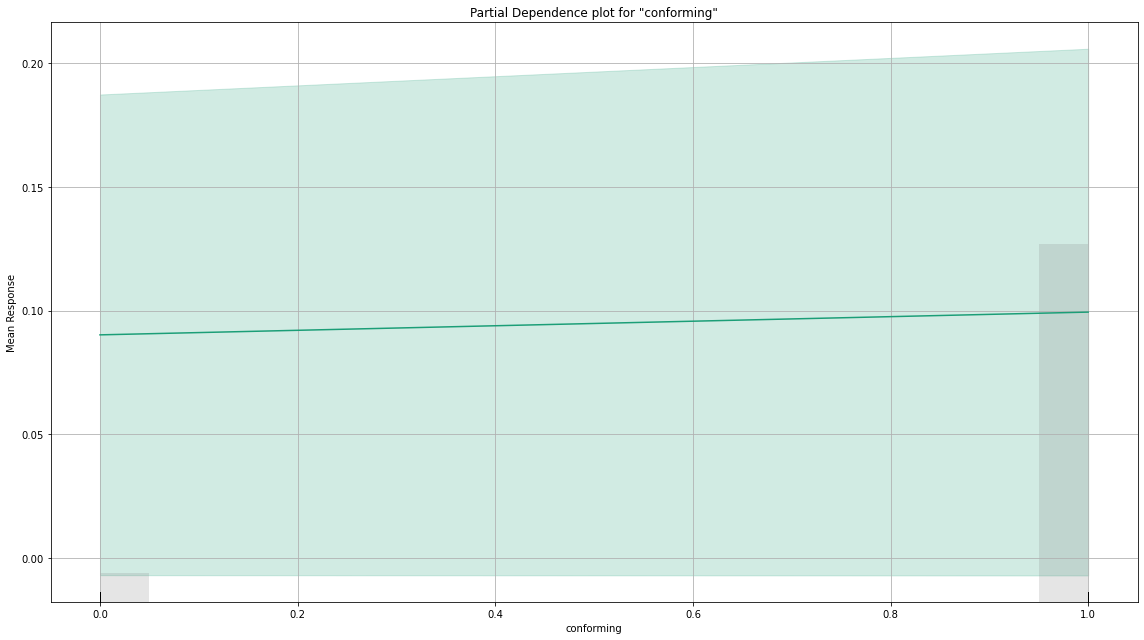

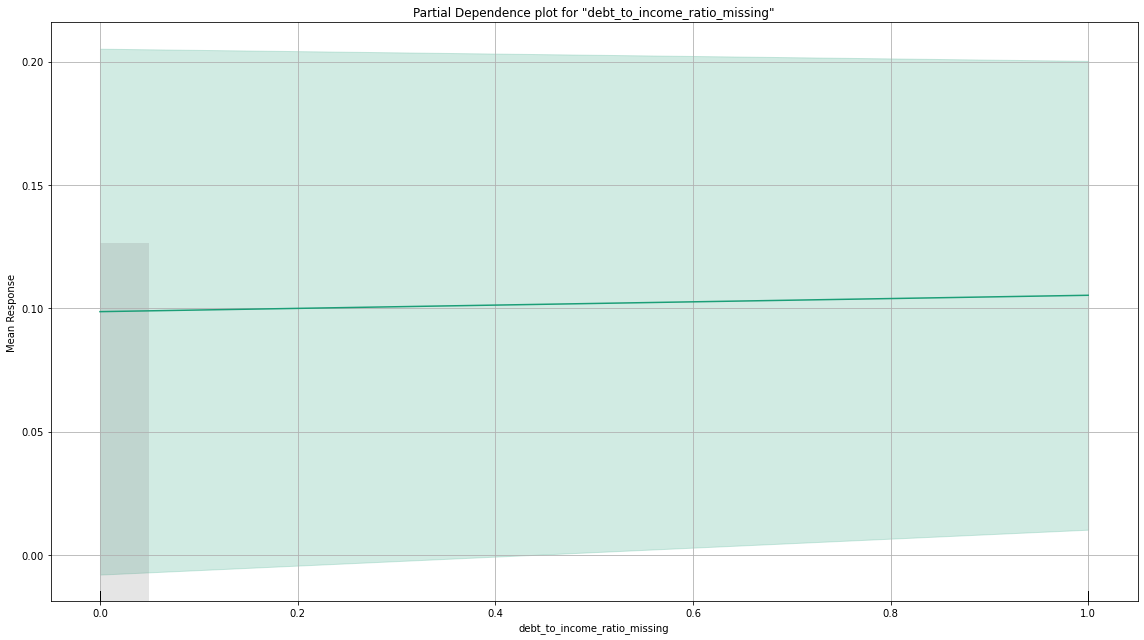

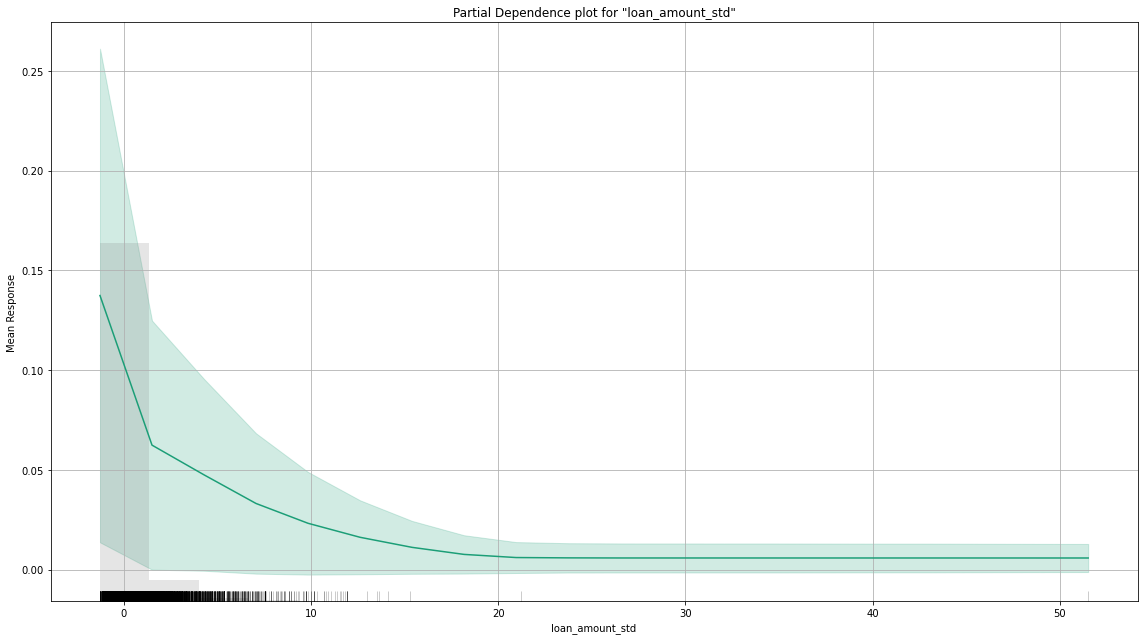

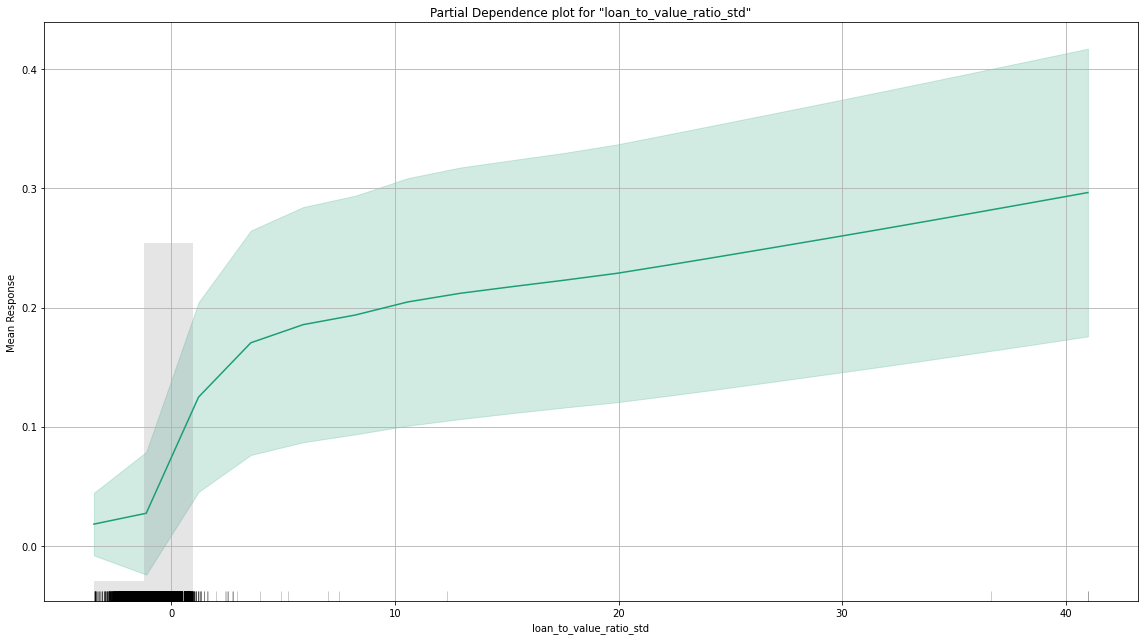

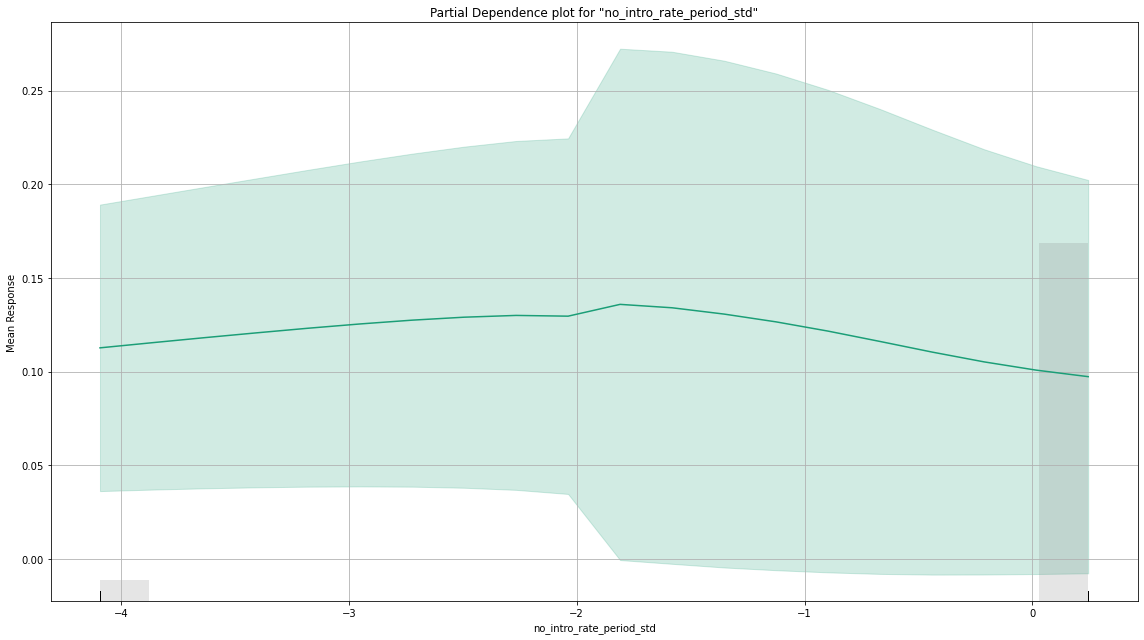

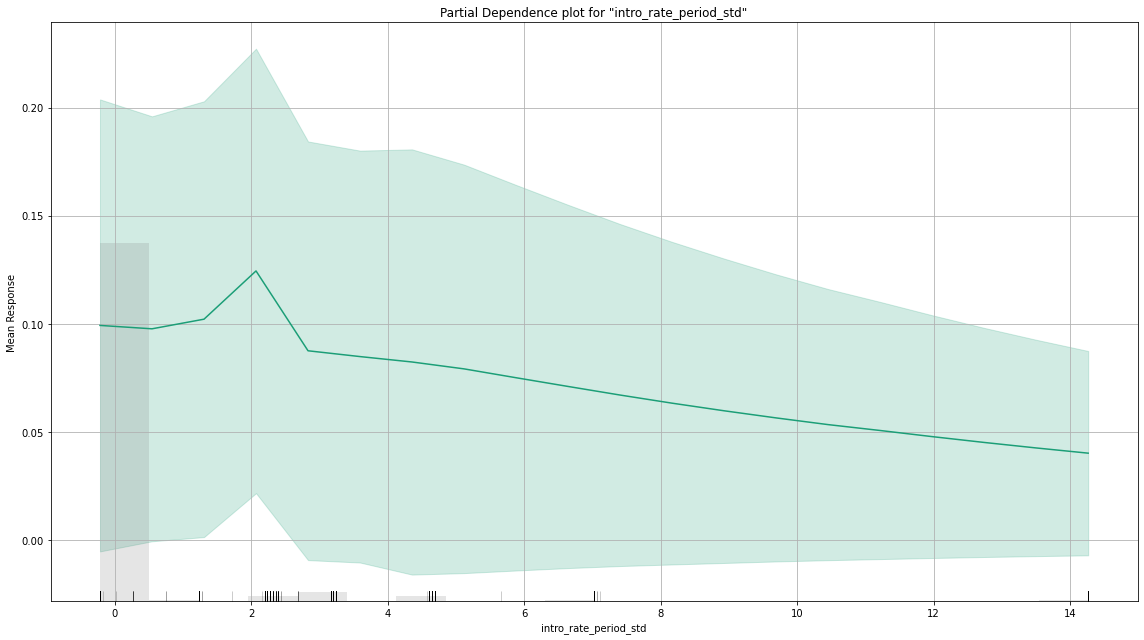

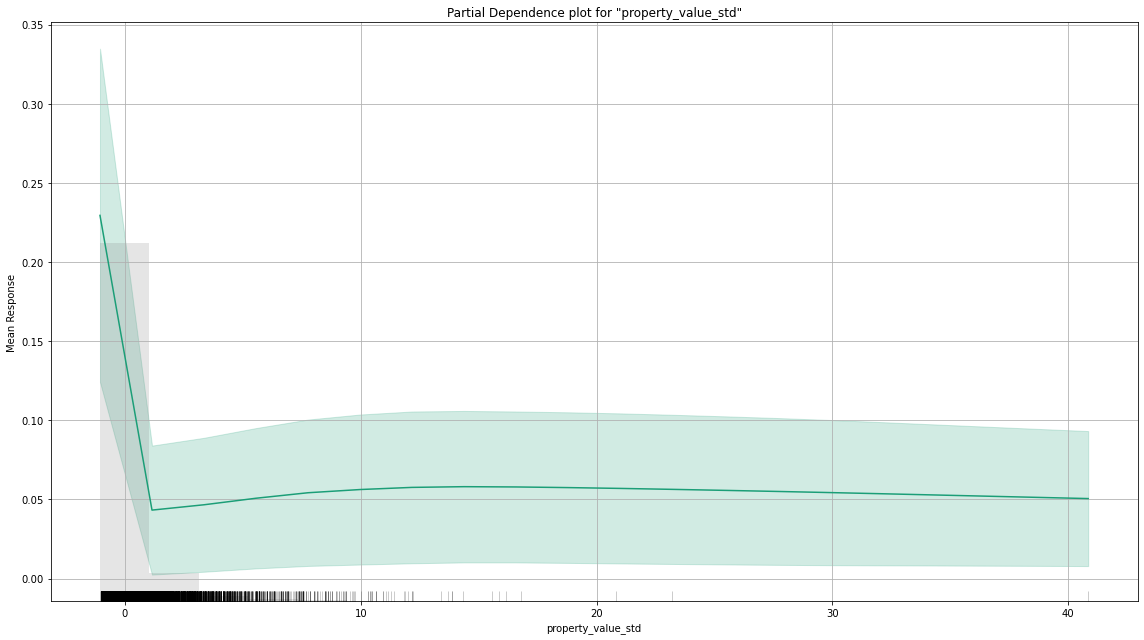

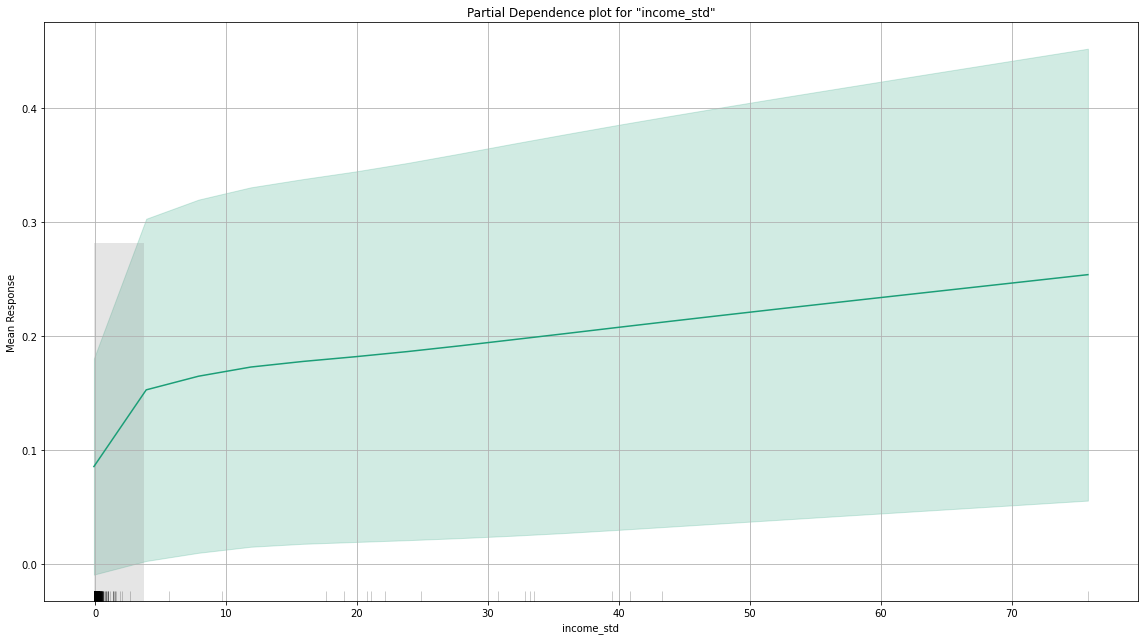

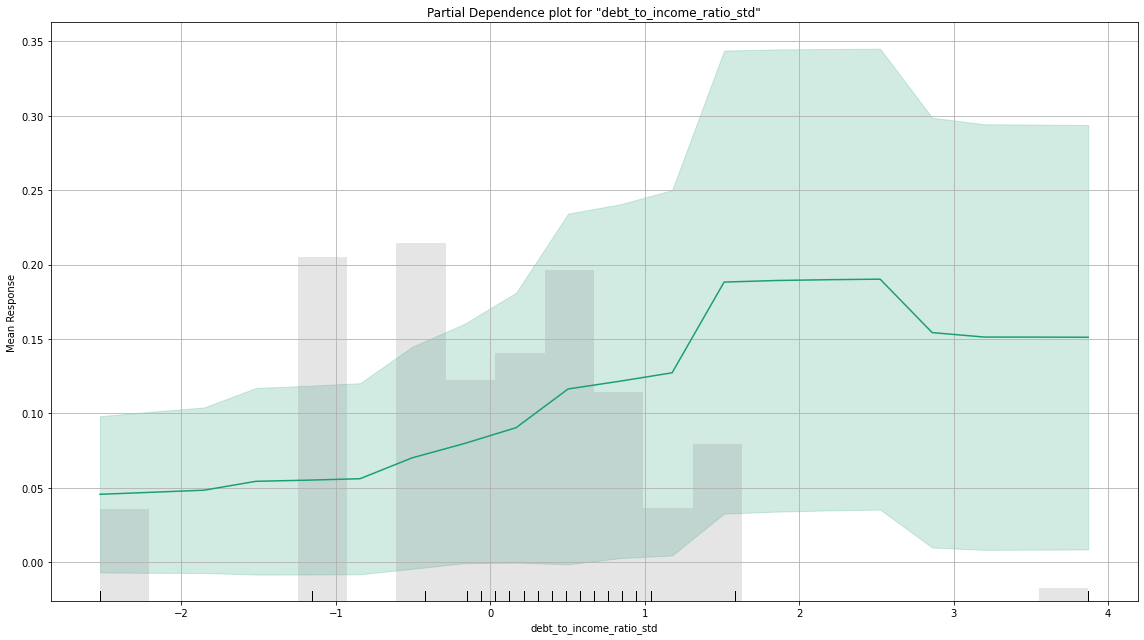

In [43]:
exa_ensenble = ensenble_h2o.explain(hvalid)